# Project Objectives

The objective of this project is to analyze a publicly available ICU dataset from Kaggle to explore whether machine learning can provide clinical insights for critical care decision-making. Specifically, the project focuses on predicting patient outcome, such as mortality, to support medical intervention and optimize resource allocation in ICU settings.

The ICU dataset presents typical of real-world clinical challenges, including sparsity, unbalanced outcome classes, missing values and limited feature dimensions. Through this project, we will:

1. Explore ICU clinical variables to understand their distributions and relationships.
2. Identify key features that most influence patient outcomes.
3. Assess the impact of missing data and implement strategies for imputation
4. Evaluate machine learning models for predictive performance and feasibility within healthcare constraints.

### Data Souce:
The dataset is publicly availabe on Kaggle - Death Classification in ICU:
https://www.kaggle.com/datasets/fdemoribajolin/death-classification-icu - containing clinical and demograpic variables relevant to ICU patient outcome.

In [ ]:
import warnings

warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
import utility as util
#from dotenv import load_dotenv
import os
import shap


In [2]:
# Load environment variables from .env file
'''
load_dotenv() 

assert "KAGGLE_USERNAME" in os.environ
assert "KAGGLE_KEY" in os.environ
'''

'\nload_dotenv() \n\nassert "KAGGLE_USERNAME" in os.environ\nassert "KAGGLE_KEY" in os.environ\n'

## Load Data

In [3]:
# Download dataset from Kaggle
#!kaggle datasets download -d fdemoribajolin/death-classification-icu -p ./data --unzip

In [4]:
X_train=pd.read_csv('./data/X_train_2025.csv')
Y_train=pd.read_csv('./data/y_train_2025.csv')

In [5]:
df=pd.concat([X_train,Y_train],axis=1)
df.head()

recordid  SAPS-I  SOFA   Age  Gender  Height  Weight  CCU  CSRU  SICU  ...  \
0    137517      -1     2  56.0     0.0     NaN    79.6    0     0     0  ...   
1    145680      10     3  72.0     1.0     NaN    70.0    0     0     0  ...   
2    138649      -1     8  81.0     0.0     NaN     NaN    0     0     0  ...   
3    149075      16     8  56.0     1.0   180.3    94.8    1     0     0  ...   
4    141408      14     7  52.0     1.0   182.9   120.6    0     1     0  ...   

   TroponinI_last  TroponinT_last  WBC_last  Weight_last  pH_last  \
0             NaN             NaN       7.3         79.6      NaN   
1             NaN            0.07       2.4         70.0     7.48   
2             NaN             NaN       7.0          NaN      NaN   
3             NaN             NaN      11.4         98.9     7.44   
4             NaN             NaN       9.0        120.6     7.43   

   MechVentStartTime  MechVentDuration  MechVentLast8Hour  UrineOutputSum  \
0                NaN               NaN                NaN             NaN   
1                NaN               NaN                NaN             NaN   
2                NaN               NaN                NaN             NaN   
3             1128.0             470.0                0.0             4.0   
4              143.0            2580.0                1.0            16.0   

   In-hospital_death  
0                  0  
1                  0  
2                  0  
3                  0  
4                  0  

[5 rows x 121 columns]

In [6]:
print('Number of rows:', df.shape[0])
print('Number of columns:', df.shape[1])

Number of rows: 3600
Number of columns: 121


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3600 entries, 0 to 3599
Columns: 121 entries, recordid to In-hospital_death
dtypes: float64(114), int64(7)
memory usage: 3.3 MB


### Dataset Overview

This ICU dataset contains **3,600 patient records** with **121 features**:

- **recordid:** Unique identifier for each patient  
- **In-hospital_death:** Binary variable indicating patient survival (`0`) or death (`1`)
- **Clinical features:** 119 columns with historical patient measurements, including vitals and laboratory results


# Data Exploratory Analysis

In [8]:
# Statistical summary
df.describe()

recordid       SAPS-I         SOFA          Age       Gender  \
count    3600.000000  3600.000000  3600.000000  3600.000000  3596.000000   
mean   140964.911389    14.187500     6.311111    64.462778     0.563126   
std      5583.521700     6.061105     4.191431    17.630796     0.496068   
min    132539.000000    -1.000000    -1.000000    15.000000     0.000000   
25%    136374.500000    11.000000     3.000000    53.000000     0.000000   
50%    140071.500000    15.000000     6.000000    67.000000     1.000000   
75%    145233.750000    18.000000     9.000000    78.000000     1.000000   
max    152851.000000    34.000000    22.000000    90.000000     1.000000   

             Height       Weight          CCU         CSRU         SICU  ...  \
count   1862.000000  3277.000000  3600.000000  3600.000000  3600.000000  ...   
mean     175.749198    81.729774     0.140556     0.213611     0.281944  ...   
std      256.371473    23.677343     0.347611     0.409912     0.450009  ...   
min      121.900000    36.500000     0.000000     0.000000     0.000000  ...   
25%      162.600000    66.000000     0.000000     0.000000     0.000000  ...   
50%      170.200000    79.000000     0.000000     0.000000     0.000000  ...   
75%      177.800000    92.000000     0.000000     0.000000     1.000000  ...   
max    11220.000000   280.000000     1.000000     1.000000     1.000000  ...   

       TroponinI_last  TroponinT_last     WBC_last  Weight_last      pH_last  \
count      175.000000      786.000000  3516.000000  2407.000000  2748.000000   
mean         6.714857        0.923537    12.361761    85.064769     7.399782   
std          9.643306        2.163239     6.309717    24.617355     0.060998   
min          0.300000        0.010000     1.000000    36.200000     7.030000   
25%          0.800000        0.040000     8.500000    68.300000     7.370000   
50%          1.700000        0.120000    11.300000    82.000000     7.410000   
75%          8.800000        0.567500    14.800000    97.400000     7.440000   
max         46.000000       19.700000   130.900000   280.000000     7.630000   

       MechVentStartTime  MechVentDuration  MechVentLast8Hour  UrineOutputSum  \
count        2264.000000        2264.00000        2264.000000     2264.000000   
mean          292.278269        1895.00530           0.617049       12.120141   
std           494.095873         876.76375           0.486214        5.818560   
min             0.000000           0.00000           0.000000        1.000000   
25%            52.000000        1140.00000           0.000000        7.000000   
50%           118.000000        2281.50000           1.000000       13.000000   
75%           241.000000        2670.00000           1.000000       16.000000   
max          2854.000000        2880.00000           1.000000       38.000000   

       In-hospital_death  
count        3600.000000  
mean            0.139722  
std             0.346747  
min             0.000000  
25%             0.000000  
50%             0.000000  
75%             0.000000  
max             1.000000  

[8 rows x 121 columns]

In [9]:
#Check if there are any duplicate rows
duplicate_check=df.duplicated().sum()
print('Number of duplicate rows:', duplicate_check)

Number of duplicate rows: 0


## Target Distribution

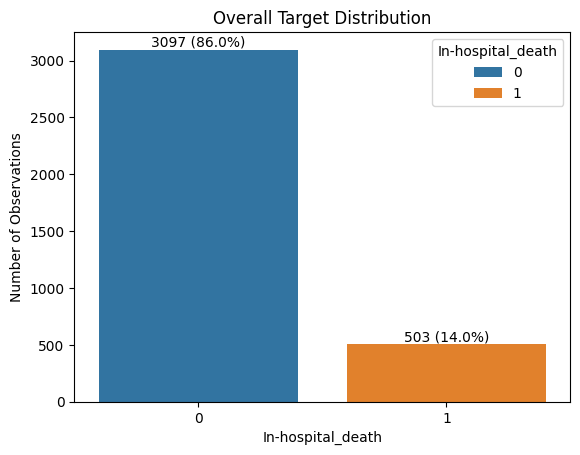

In [10]:
util.plot_target_distribution(df,'In-hospital_death', 'Overall Target Distribution')

## Feature Distribution

In [11]:
numeric_cols=df.select_dtypes(include=['int64','float64']).columns.tolist()
# Exclude columns that contains the unique identifer, target label, binary flagging indicators, timestamp
columns_to_exclude=['recordid','In-hospital_death','CCU','CSRU','SICU','Gender','MechVentLast8Hour','MechVentStartTime']
for column in columns_to_exclude:
  numeric_cols.remove(column)
numeric_cols.sort()

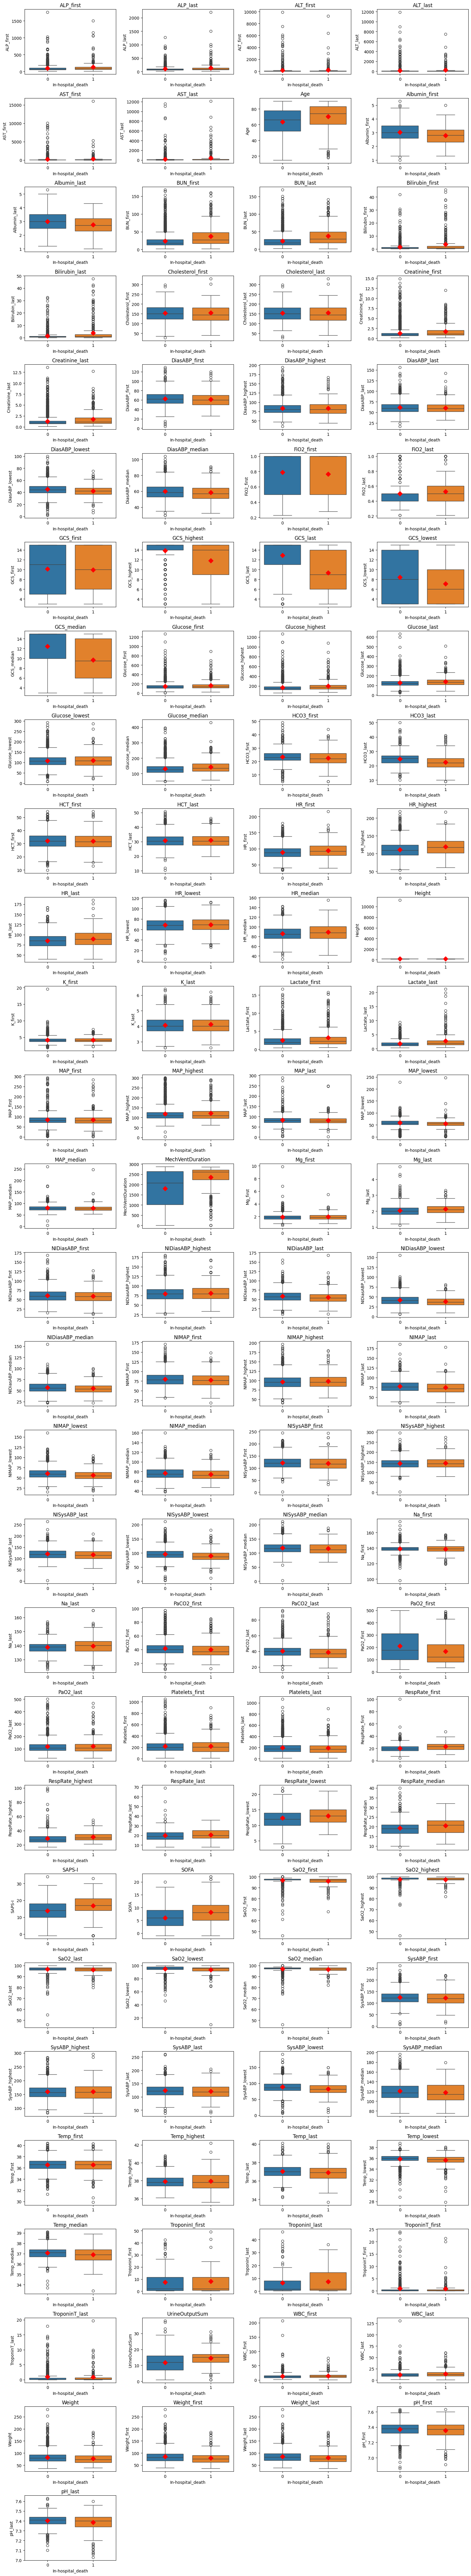

In [12]:
#Raw numeric features distribution
util.plot_boxplots(df, numeric_cols, 'In-hospital_death')

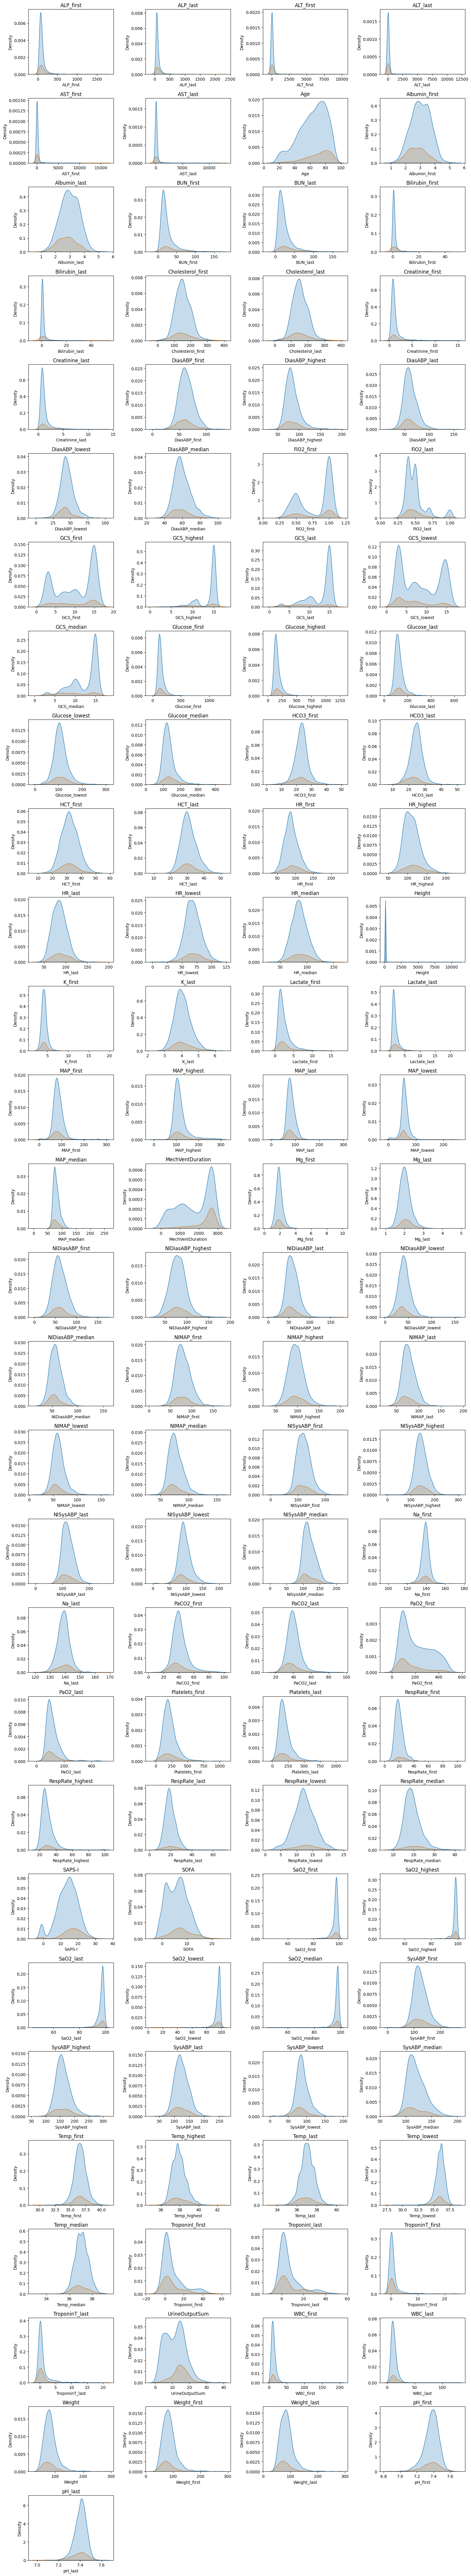

In [13]:
# Plot KDE plots for raw numeric features
util.plot_kde_plots(df, numeric_cols, 'In-hospital_death')

### Distribution Analysis

The target outcome is highly imbalanced, with **14% non-survival cases** and **86% survival cases**.

Raw numeric features show substantial overlap between survival (`0`) and non-survival (`1`) patients, as observed in both boxplots and Kernel Density Estimation (KDE) plots. This overlap indicates that individual raw features may have limited discriminative power when considered independently.

Several variables also contain extreme outliers. While some of these values may reflect rare but valid clinical observations, others are likely due to data entry errors. For example, recorded heights exceeding 1,000 units when the population mean is approximately 175 units.

Under typical circumstances, such outliers would be reviewed with domain expertise to guide data cleaning and preprocessing. In this analysis, in the absence of clinical guidance, a conservative, data-driven approach is adopted: only universally implausible values are excluded, while other extreme observations are retained for modeling.


## Missing Data

Significant missing data is observed, which is expected in ICU datasets where tests are ordered based on patient condition and evolving symptoms.

In [15]:
data_fraction = df.notnull().mean(axis=1)

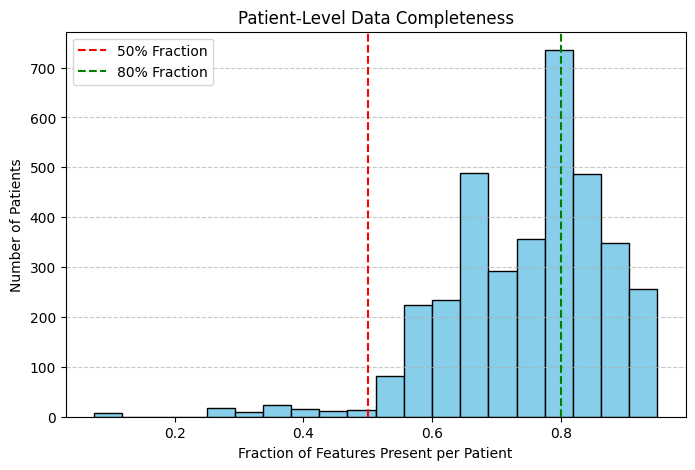

In [16]:
plt.figure(figsize=(8,5))
plt.hist(data_fraction, bins=20, color='skyblue', edgecolor='black')
plt.axvline(0.5, color='red', linestyle='--', label='50% Fraction')
plt.axvline(0.8, color='green', linestyle='--', label='80% Fraction')
plt.xlabel('Fraction of Features Present per Patient')
plt.ylabel('Number of Patients')
plt.title('Patient-Level Data Completeness')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

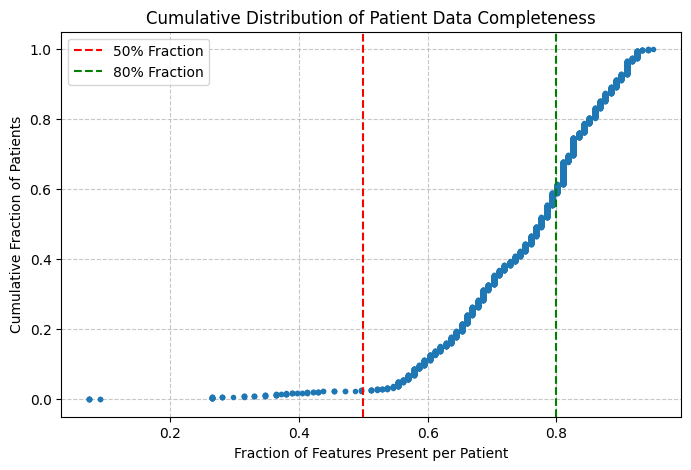

In [17]:
sorted_frac = np.sort(data_fraction)
cdf = np.arange(1, len(data_fraction)+1) / len(data_fraction)

plt.figure(figsize=(8,5))
plt.plot(sorted_frac, cdf, marker='.', linestyle='none')
plt.axvline(0.5, color='red', linestyle='--', label='50% Fraction')
plt.axvline(0.8, color='green', linestyle='--', label='80% Fraction')
plt.xlabel('Fraction of Features Present per Patient')
plt.ylabel('Cumulative Fraction of Patients')
plt.title('Cumulative Distribution of Patient Data Completeness')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

In [255]:
thresholds = [.4, 0.5, 0.6, 0.7, 0.8, 0.9]
for t in thresholds:
    kept = (data_fraction >= t).sum()
    dropped = df.shape[0] - kept
    print(f"Fraction of patients missing {t*100:.0f}% of Features: Keep {(kept/df.shape[0]*100):.3f}% ({kept}/{df.shape[0]}) patients, Drop {dropped} patients")

Fraction of patients missing 40% of Features: Keep 98.167% (3534/3600) patients, Drop 66 patients
Fraction of patients missing 50% of Features: Keep 97.444% (3508/3600) patients, Drop 92 patients
Fraction of patients missing 60% of Features: Keep 88.778% (3196/3600) patients, Drop 404 patients
Fraction of patients missing 70% of Features: Keep 67.222% (2420/3600) patients, Drop 1180 patients
Fraction of patients missing 80% of Features: Keep 41.056% (1478/3600) patients, Drop 2122 patients
Fraction of patients missing 90% of Features: Keep 8.750% (315/3600) patients, Drop 3285 patients


In [257]:
# Patients with less than 50% completeness
data_fraction[data_fraction<=0.4]



16      0.396694
28      0.363636
315     0.380165
337     0.388430
359     0.264463
          ...   
3261    0.264463
3265    0.380165
3292    0.347107
3433    0.280992
3543    0.363636
Length: 66, dtype: float64

In [259]:
# Keep data if completeness > 50%
df_keep=df[data_fraction>0.4]
print(df_keep.head(20))

    recordid  SAPS-I  SOFA   Age  Gender  Height  Weight  CCU  CSRU  SICU  \
0     137517      -1     2  56.0     0.0     NaN    79.6    0     0     0   
1     145680      10     3  72.0     1.0     NaN    70.0    0     0     0   
2     138649      -1     8  81.0     0.0     NaN     NaN    0     0     0   
3     149075      16     8  56.0     1.0   180.3    94.8    1     0     0   
4     141408      14     7  52.0     1.0   182.9   120.6    0     1     0   
5     150941      20    12  76.0     1.0   175.3    96.5    0     1     0   
6     132584      28    16  78.0     0.0     NaN    72.8    0     0     0   
7     136768      25    17  40.0     1.0   177.8    75.0    0     0     1   
8     133282      21    13  73.0     0.0   165.1    79.5    0     1     0   
9     149549      14     3  76.0     1.0     NaN   112.0    0     0     0   
10    147051       9     1  74.0     0.0   157.5    75.0    1     0     0   
11    135770      13     4  25.0     0.0     NaN    65.0    0     0     1   

In [260]:
missing_summary_df=pd.DataFrame({
    '# Missing': df_keep.isnull().sum(),
    '% Missing': df_keep.isnull().mean()*100}).sort_values(by='# Missing', ascending=False)
print('Top 20 missing data columns:', missing_summary_df.head(20))

Top 20 missing data columns:                    # Missing  % Missing
TroponinI_first         3359  95.048104
TroponinI_last          3359  95.048104
Cholesterol_last        3261  92.275042
Cholesterol_first       3261  92.275042
TroponinT_first         2758  78.041879
TroponinT_last          2758  78.041879
RespRate_highest        2550  72.156197
RespRate_lowest         2550  72.156197
RespRate_first          2550  72.156197
RespRate_last           2550  72.156197
RespRate_median         2550  72.156197
Albumin_first           2077  58.771930
Albumin_last            2077  58.771930
ALP_first               2019  57.130730
ALP_last                2019  57.130730
Bilirubin_last          1993  56.395020
Bilirubin_first         1993  56.395020
ALT_last                1992  56.366723
ALT_first               1992  56.366723
AST_first               1989  56.281834


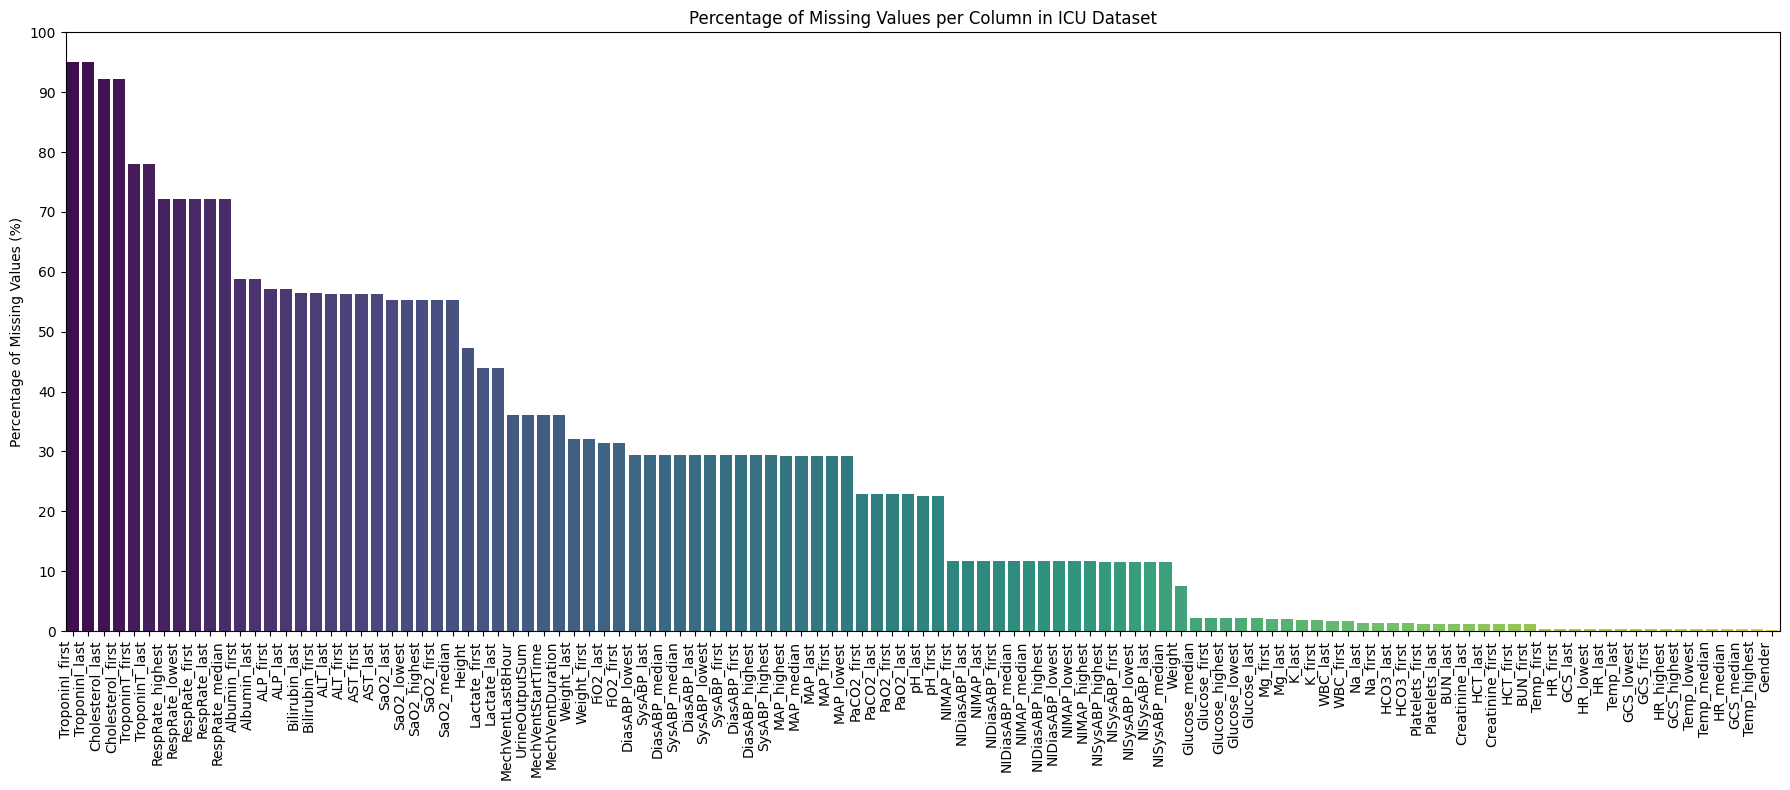

In [261]:
# Filter columns that have at least one missing value
missing_pct = missing_summary_df[missing_summary_df['% Missing'] > 0]

# Plot Missing Data Distribution
plt.figure(figsize=(18,8))
sns.barplot(x=missing_pct.index, y=missing_pct['% Missing'], palette='viridis')
plt.xticks(rotation=90, ha='right')
plt.ylabel('Percentage of Missing Values (%)')
plt.xlabel('')
plt.title('Percentage of Missing Values per Column in ICU Dataset')
plt.ylim(0, 100)
plt.yticks(range(0,101,10))
plt.tight_layout()
plt.show()


## Data Cleaning

Height values exceeding 250 units fall outside commonly accepted human ranges and are therefore considered implausible, likely due to data entry or measurement errors. Rather than removing the affected records, these values are set to `NaN` to indicate missing measurements and to preserve the underlying patient observations.

The MechVentStartTime column represents the timestamp when mechanical ventilation was initiated. However, in the dataset, the raw values are inconsistent and difficult to interpret (e.g., 0, 117, 2809), which do not correspond to meaningful datetime values.  




In [279]:
# 99th percentile in Height
df_keep.Height.quantile(0.99)

np.float64(193.0)

In [280]:
# Patient with height value >250 are like measuring 
df_keep[df_keep.Height>250][['recordid','Age','Height','Weight','In-hospital_death']]

recordid   Age   Height  Weight  In-hospital_death
167     140620  81.0    308.0    97.3                  0
177     142140  82.0    286.0    94.1                  0
1217    136967  88.0    301.4    99.3                  0
3229    147129  63.0  11220.0    57.9                  0

In [281]:
# Set unrealist height values >250 to NaN
df_clean=df_keep.copy()
df_clean.loc[df_clean.Height>250, 'Height'] = np.nan

#Summary statistics after cleaning
df_clean[['Height']].describe()

Height
count  1857.000000
mean    169.599735
std      11.023090
min     121.900000
25%     162.600000
50%     170.200000
75%     177.800000
max     208.300000

In [282]:
df_clean=df_clean.drop(columns=['MechVentStartTime'],axis=1)  # Dropping this column due to inconsistent and difficult to interpret

## Data Split

The dataset is divided using a **70/30 split**, with **70% of the data used for training** and **30% reserved for testing**.

In [283]:
X=df_clean.drop(columns=['recordid','In-hospital_death'],axis=1)
y=df_clean['In-hospital_death']

X_train,X_test,y_train,y_test=train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

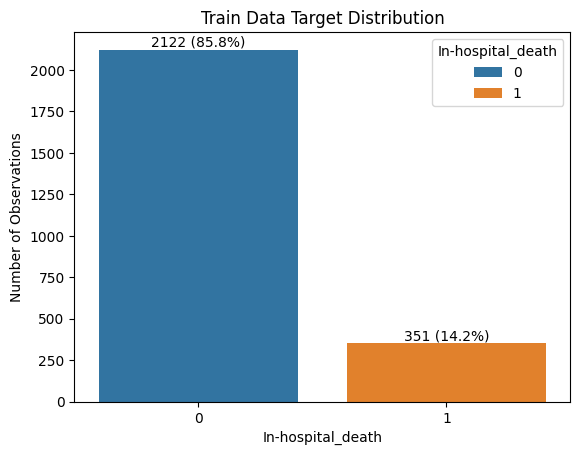

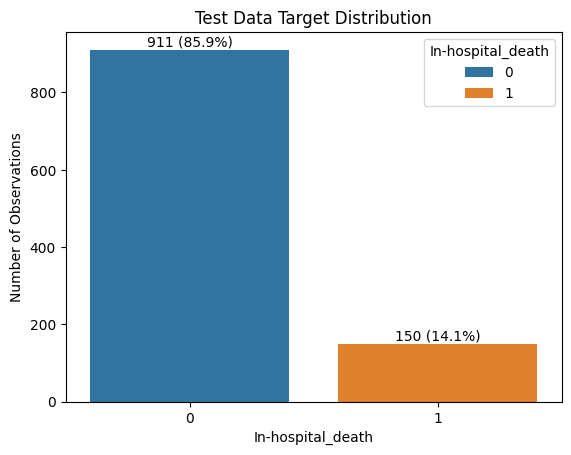

In [284]:
util.plot_target_distribution(y_train,'In-hospital_death', 'Train Data Target Distribution')
util.plot_target_distribution(y_test,'In-hospital_death', 'Test Data Target Distribution')

## Data Impuation

Because clinical tests in the ICU are ordered based on patient-specific conditions, missing data may reflect clinical decision-making rather than data quality issues and can carry predictive signal for patient outcomes. Based on this understanding, the following imputation guidelines are applied:

* Features with >= 20% missing data include a binary indicator flag denoting whether the test was performed (1) or not performed (0).
* Features with > 70% missing data are dropped due to insufficient observations, particularly among the minority positive (dead) class.
* Features with < 70% missing data are imputed using clinically appropriate values such as the median, mode, or patient-specific historical measurements.

In [285]:
missing_pct_70=missing_pct[missing_pct['% Missing']>70] #Features with >70% missing
missing_pct_gt20=missing_pct[(missing_pct['% Missing']>=20) & (missing_pct['% Missing']<=70)] #Features with 20-70% missing
missing_pct_lt20=missing_pct[missing_pct['% Missing']<20] #Features with <20% missing
missing_pct=missing_pct[missing_pct['% Missing']>0] #Features with missing values   

In [286]:
median_imputer_cols=missing_pct.index.tolist()
median_imputer_cols.remove('MechVentStartTime')

In [287]:
#Compute median value for imputation from training data
median_values = X_train[median_imputer_cols].median()

### Features with >70% missing data

* Troponin
* Cholesterol
* Respiratory Rate

In [288]:
# Features with >70% missing values
missing_pct_70=missing_pct[missing_pct['% Missing']>70]
print(missing_pct_70)

                   # Missing  % Missing
TroponinI_first         3359  95.048104
TroponinI_last          3359  95.048104
Cholesterol_last        3261  92.275042
Cholesterol_first       3261  92.275042
TroponinT_first         2758  78.041879
TroponinT_last          2758  78.041879
RespRate_highest        2550  72.156197
RespRate_lowest         2550  72.156197
RespRate_first          2550  72.156197
RespRate_last           2550  72.156197
RespRate_median         2550  72.156197


In [289]:
#Check if TroponinI or TroponinT was tested
Troponin_cols=['TroponinI_first','TroponinI_last','TroponinT_first','TroponinT_last']
troponin_measured = df[df[Troponin_cols].notnull().any(axis=1)][Troponin_cols]
print(f"Number of records Troponin was tested: {len(troponin_measured)}")

#Check if both TroponinI and TroponinT were tested
troponin_both_measured = X_train[
    df[['TroponinI_first','TroponinI_last']].notnull().any(axis=1) &
    df[['TroponinT_first','TroponinT_last']].notnull().any(axis=1)][Troponin_cols]

print(f"Number of records both TroponinI and TroponinT were tested: {len(troponin_both_measured)}")

Number of records Troponin was tested: 961
Number of records both TroponinI and TroponinT were tested: 0


In [290]:
#Apply Flagging indicator for Troponin and remove original columns
X_train=util.create_measured_flag(X_train, Troponin_cols, 'Troponin_tested', True)
X_test=util.create_measured_flag(X_test, Troponin_cols, 'Troponin_tested', True)

#Check Distribution
print(X_train['Troponin_tested'].value_counts())
print(X_test['Troponin_tested'].value_counts())

Troponin_tested
0    1810
1     663
Name: count, dtype: int64
Troponin_tested
0    773
1    288
Name: count, dtype: int64


In [291]:
#Apply flagging indicator for the Cholestrole and remove original volumns
chol_cols=['Cholesterol_first','Cholesterol_last']
X_train=util.create_measured_flag(X_train, chol_cols, 'Cholesterol_tested', True)
X_test=util.create_measured_flag(X_test, chol_cols, 'Cholesterol_tested', True)

print(X_train['Cholesterol_tested'].value_counts())
print(X_test['Cholesterol_tested'].value_counts())

Cholesterol_tested
0    2296
1     177
Name: count, dtype: int64
Cholesterol_tested
0    965
1     96
Name: count, dtype: int64


In [292]:
#Apply flagging indicator for the Respiration Rate
resp_rate_cols=['RespRate_last','RespRate_highest','RespRate_lowest','RespRate_first','RespRate_median']
X_train=util.create_measured_flag(X_train, resp_rate_cols, 'RespRate_tested', True)
X_test=util.create_measured_flag(X_test, resp_rate_cols, 'RespRate_tested', True)

print(X_train['RespRate_tested'].value_counts())
print(X_test['RespRate_tested'].value_counts())

RespRate_tested
0    1792
1     681
Name: count, dtype: int64
RespRate_tested
0    758
1    303
Name: count, dtype: int64


### Features with 20% to 70% missing values

In [293]:
# Features with >20% and <70% missing values
print(missing_pct_gt20.index.sort_values())

Index(['ALP_first', 'ALP_last', 'ALT_first', 'ALT_last', 'AST_first',
       'AST_last', 'Albumin_first', 'Albumin_last', 'Bilirubin_first',
       'Bilirubin_last', 'DiasABP_first', 'DiasABP_highest', 'DiasABP_last',
       'DiasABP_lowest', 'DiasABP_median', 'FiO2_first', 'FiO2_last', 'Height',
       'Lactate_first', 'Lactate_last', 'MAP_first', 'MAP_highest', 'MAP_last',
       'MAP_lowest', 'MAP_median', 'MechVentDuration', 'MechVentLast8Hour',
       'MechVentStartTime', 'PaCO2_first', 'PaCO2_last', 'PaO2_first',
       'PaO2_last', 'SaO2_first', 'SaO2_highest', 'SaO2_last', 'SaO2_lowest',
       'SaO2_median', 'SysABP_first', 'SysABP_highest', 'SysABP_last',
       'SysABP_lowest', 'SysABP_median', 'UrineOutputSum', 'Weight_first',
       'Weight_last', 'pH_first', 'pH_last'],
      dtype='object')


In [294]:
# Add binary flagging indicator for features with 20-70% missing values
ALP_cols=['ALP_first','ALP_last']
X_train=util.create_measured_flag(X_train, ALP_cols, 'ALP_tested', False)
X_test=util.create_measured_flag(X_test, ALP_cols, 'ALP_tested', False) 

ALT_cols=['ALT_first','ALT_last']
X_train=util.create_measured_flag(X_train, ALT_cols, 'ALT_tested', False)
X_test=util.create_measured_flag(X_test, ALT_cols, 'ALT_tested', False)

AST_cols=['AST_first','AST_last']
X_train=util.create_measured_flag(X_train, AST_cols, 'AST_tested',False)
X_test=util.create_measured_flag(X_test, AST_cols, 'AST_tested',False)

Albumin_cols=['Albumin_first','Albumin_last']
X_train=util.create_measured_flag(X_train, Albumin_cols, 'Albumin_tested',False)
X_test=util.create_measured_flag(X_test, Albumin_cols, 'Albumin_tested',False)  

Bilirubin_cols=['Bilirubin_first','Bilirubin_last']
X_train=util.create_measured_flag(X_train, Bilirubin_cols, 'Bilirubin_tested',False)
X_test=util.create_measured_flag(X_test, Bilirubin_cols, 'Bilirubin_tested',False)

DiasABP_cols=['DiasABP_first','DiasABP_last','DiasABP_highest','DiasABP_lowest','DiasABP_median']
X_train=util.create_measured_flag(X_train, DiasABP_cols, 'DiasABP_tested',False)
X_test=util.create_measured_flag(X_test, DiasABP_cols, 'DiasABP_tested',False)

FiO2_cols=['FiO2_first','FiO2_last']
X_train=util.create_measured_flag(X_train, FiO2_cols, 'FiO2_tested',False)
X_test=util.create_measured_flag(X_test, FiO2_cols, 'FiO2_tested',False)

X_train=util.create_measured_flag(X_train, ['Height'], 'Height_tested',False)
X_test=util.create_measured_flag(X_test, ['Height'], 'Height_tested',False)

Lactate_cols=['Lactate_first','Lactate_last']
X_train=util.create_measured_flag(X_train, Lactate_cols, 'Lactate_tested',False)
X_test=util.create_measured_flag(X_test, Lactate_cols, 'Lactate_tested',False)

MAP_cols=['MAP_first','MAP_last','MAP_highest','MAP_lowest','MAP_median']
X_train=util.create_measured_flag(X_train, MAP_cols, 'MAP_tested',False)
X_test=util.create_measured_flag(X_test, MAP_cols, 'MAP_tested',False)

MechVent_cols=['MechVentDuration','MechVentLast8Hour']
X_train=util.create_measured_flag(X_train, MechVent_cols, 'MechVent_tested',False)
X_test=util.create_measured_flag(X_test, MechVent_cols, 'MechVent_tested',False)

SaO2_cols=['SaO2_first','SaO2_last','SaO2_highest','SaO2_lowest','SaO2_median']
X_train=util.create_measured_flag(X_train, SaO2_cols, 'SaO2_tested',False)
X_test=util.create_measured_flag(X_test, SaO2_cols, 'SaO2_tested',False)

SysABP_cols=['SysABP_first','SysABP_last','SysABP_highest','SysABP_lowest','SysABP_median']
X_train=util.create_measured_flag(X_train, SysABP_cols, 'SysABP_tested',False)
X_test=util.create_measured_flag(X_test, SysABP_cols, 'SysABP_tested',False)    

X_train=util.create_measured_flag(X_train, ['UrineOutputSum'], 'UrineOutput_tested',False)
X_test=util.create_measured_flag(X_test, ['UrineOutputSum'], 'UrineOutput_tested',False)

Weight_cols=['Weight_first','Weight_last']
X_train=util.create_measured_flag(X_train, Weight_cols, 'Weight_tested',False)
X_test=util.create_measured_flag(X_test, Weight_cols, 'Weight_tested',False)



In [295]:
# Fill in median values for imputation except for weights
cols_to_impute_gt20 = missing_pct_gt20.index.difference(['Weight_first', 'Weight_last'])
for col in cols_to_impute_gt20:
    if col != 'MechVentStartTime':
        X_train[col].fillna(median_values[col], inplace=True)
        X_test[col].fillna(median_values[col], inplace=True)   

#### Weight Measurements

Fill in missing values with historical values if data exist. Otherwise, apply the median values.

In [296]:
#Check the numbers with missing values in weights
print(df_clean[['Weight_first','Weight_last','Weight']].isnull().sum())

Weight_first    1132
Weight_last     1132
Weight           264
dtype: int64


In [297]:
# Check the records with any missing values in weights
df_clean[df_clean[['Weight_first','Weight_last','Weight']].isnull().any(axis=1)][['recordid','Weight_first','Weight_last','Weight','In-hospital_death']]

recordid  Weight_first  Weight_last  Weight  In-hospital_death
2       138649           NaN          NaN     NaN                  0
5       150941           NaN          NaN    96.5                  0
6       132584           NaN          NaN    72.8                  0
7       136768           NaN          NaN    75.0                  0
9       149549           NaN          NaN   112.0                  0
...        ...           ...          ...     ...                ...
3581    136941           NaN          NaN    81.8                  0
3584    140001           NaN          NaN    60.0                  1
3585    141936           NaN          NaN    70.0                  0
3594    135631           NaN          NaN    75.0                  0
3599    139102           NaN          NaN     NaN                  0

[1157 rows x 5 columns]

In [298]:
# Fill missing values with historical measurements for Weights
def fill_weight(x_data):

    #Fill weight first and weight last with historical weight
    x_data['Weight_first']=x_data['Weight_first'].fillna(x_data['Weight'])
    x_data['Weight_last']=x_data['Weight_last'].fillna(x_data['Weight'])

    #Fill weight with first weight
    x_data['Weight']=x_data['Weight'].fillna(x_data['Weight_last'])
    
    return x_data
X_train=fill_weight(X_train)
X_test=fill_weight(X_test)  

In [299]:
# Fill in median values for imputation Weights
for col in ['Weight_first', 'Weight_last', 'Weight']:
    X_train[col].fillna(median_values[col], inplace=True)
    X_test[col].fillna(median_values[col], inplace=True)

### Features with <20% missing data

In [300]:
print(missing_pct_lt20.index.sort_values())

Index(['BUN_first', 'BUN_last', 'Creatinine_first', 'Creatinine_last',
       'GCS_first', 'GCS_highest', 'GCS_last', 'GCS_lowest', 'GCS_median',
       'Gender', 'Glucose_first', 'Glucose_highest', 'Glucose_last',
       'Glucose_lowest', 'Glucose_median', 'HCO3_first', 'HCO3_last',
       'HCT_first', 'HCT_last', 'HR_first', 'HR_highest', 'HR_last',
       'HR_lowest', 'HR_median', 'K_first', 'K_last', 'Mg_first', 'Mg_last',
       'NIDiasABP_first', 'NIDiasABP_highest', 'NIDiasABP_last',
       'NIDiasABP_lowest', 'NIDiasABP_median', 'NIMAP_first', 'NIMAP_highest',
       'NIMAP_last', 'NIMAP_lowest', 'NIMAP_median', 'NISysABP_first',
       'NISysABP_highest', 'NISysABP_last', 'NISysABP_lowest',
       'NISysABP_median', 'Na_first', 'Na_last', 'Platelets_first',
       'Platelets_last', 'Temp_first', 'Temp_highest', 'Temp_last',
       'Temp_lowest', 'Temp_median', 'WBC_first', 'WBC_last', 'Weight'],
      dtype='object')


In [301]:
# Features to fill in with median values
cols_to_impute_lt20 = missing_pct_lt20.index.difference(['Gender', 'Weight'])
for col in cols_to_impute_lt20:
    X_train[col].fillna(median_values[col], inplace=True)
    X_test[col].fillna(median_values[col], inplace=True)

In [302]:
# Gender to fill in with mode value
Gender_mode=X_train['Gender'].mode()[0]

X_train['Gender'].fillna(Gender_mode, inplace=True)
X_test['Gender'].fillna(Gender_mode, inplace=True)

In [303]:
# Verify no missing values remain
print('Missing values in X_train after imputation:', X_train.isnull().sum().sum())
print('Missing values in X_test after imputation:', X_test.isnull().sum().sum())

Missing values in X_train after imputation: 0
Missing values in X_test after imputation: 0


## Univariate Statistical Feature Assessment

Exploratory visualization using boxplots and KDE plots indicated that most numeric features are not normally distributed. 
To quantify the discriminative power of each feature, the following statistical tests are applied:

- **Numeric features**: Mann–Whitney U test with effect size to assess whether the distributions differ between the survival and non-survival groups.
- **Binary features and missingness indicators**: Fisher’s exact test and Odds Ratio to evaluate association with outcome.



In [304]:
train_df=pd.concat([X_train, y_train], axis=1)

In [305]:
# Get the binary flagging indicator columns
binary_cols = [col for col in train_df.columns if col.endswith('_tested')] + ['Gender','CCU','CSRU','SICU','MechVentLast8Hour']

# Get the numeric columns after imputation
numeric_cols_after_imputation = [col for col in train_df.select_dtypes(include=['int64','float64']).columns.tolist() if col not in binary_cols + ['In-hospital_death']]

### Mann-Whitney U and Effect Size on Numeric Features

Objective: Assess whether the distributions of numeric features differ between the survival and non-survival groups.

**Null Hypothesis (H₀):** The distribution of a feature is the same between the survival and non-survival groups.  
**Alternative Hypothesis (H₁):** The distribution of a feature differs between the survival and non-survival groups.

Effect size is quantified using the **rank-biserial correlation (r₍rb₎)**, which measures the magnitude of the distributional difference:
- Effect Size < 0.1: Negligible effect
- Effect Size > 0.1 to 0.3: Small effect
- Effect Size > 0.3 to 0.5: Medium effect
- Effect size > 0.5: Large effect

In [306]:
#Call the mann_whitney_u_test function
mann_whitney_u_test_df=util.mann_whitney_u_test(train_df, outcome_col='In-hospital_death', numeric_cols=numeric_cols_after_imputation)

# Sort by p-value and filter significant features
mann_whitney_u_test_df=mann_whitney_u_test_df.sort_values(by='p-value', ascending=True)

# Add effect size interpretation
mann_whitney_u_test_df['Effect Size Interpretation'] = mann_whitney_u_test_df['Effect Size Abs'].apply(util.interpret_effect_size)

In [307]:
# Numeric Features with no significant difference
NoSignificantEffect=mann_whitney_u_test_df[mann_whitney_u_test_df['p-value']>=0.05].index.tolist()

In [308]:
# Numeric Features with no significant difference
NoSignificant_Features=mann_whitney_u_test_df[mann_whitney_u_test_df['p-value']>=0.05]
NoSignificant_Features

U-statistic   p-value  Median Survived  \
Feature                                                     
MAP_median            395997.0  0.053293           78.000   
SysABP_median         395914.5  0.054103          117.000   
DiasABP_last          394301.0  0.072489           60.000   
MAP_last              393517.0  0.083587           81.000   
WBC_first             351093.5  0.085381           11.750   
HCT_first             393079.0  0.095343           31.800   
Mg_first              351956.5  0.097658            1.900   
NIDiasABP_first       390079.5  0.153254           59.000   
AST_first             357937.0  0.195859           44.000   
SysABP_last           388205.5  0.196020          122.000   
FiO2_last             359551.0  0.251195            0.500   
MAP_first             385975.0  0.266405           82.000   
SysABP_first          385657.0  0.278133          122.000   
HCT_last              384935.0  0.312180           30.300   
ALT_last              362867.5  0.392837           30.000   
NIMAP_first           382630.5  0.408974           77.000   
Height                381798.5  0.414817          170.200   
HR_lowest             362454.0  0.421572           68.000   
Platelets_last        382312.0  0.424311          174.000   
NISysABP_first        382207.5  0.428551          118.000   
Glucose_lowest        362774.5  0.436753          106.000   
Na_first              381344.0  0.469509          139.000   
GCS_first             380607.0  0.493710           11.000   
DiasABP_highest       379819.5  0.543859           81.000   
K_last                364928.5  0.545139            4.000   
NIDiasABP_highest     366258.5  0.618981           79.000   
Temp_highest          378566.0  0.619078           37.800   
ALT_first             368284.5  0.712066           30.000   
Platelets_first       375613.0  0.796130          199.000   
MAP_highest           375366.0  0.808857          109.000   
SysABP_highest        374363.5  0.873031          156.000   
PaO2_last             370542.0  0.879344          105.000   
NISysABP_highest      370631.5  0.885682          142.000   
NIMAP_highest         370824.5  0.898065           95.165   
K_first               371582.0  0.946624            4.100   
Temp_first            372462.0  0.996746           36.600   

                   Median Non-Survived  Effect Size  Effect Size Abs  \
Feature                                                                
MAP_median                      78.000    -0.063333         0.063333   
SysABP_median                  117.000    -0.063112         0.063112   
DiasABP_last                    60.000    -0.058779         0.058779   
MAP_last                        81.000    -0.056674         0.056674   
WBC_first                       12.100     0.057242         0.057242   
HCT_first                       31.100    -0.055498         0.055498   
Mg_first                         1.900     0.054925         0.054925   
NIDiasABP_first                 59.000    -0.047444         0.047444   
AST_first                       44.000     0.038866         0.038866   
SysABP_last                    122.000    -0.042411         0.042411   
FiO2_last                        0.500     0.034532         0.034532   
MAP_first                       82.000    -0.036422         0.036422   
SysABP_first                   122.000    -0.035568         0.035568   
HCT_last                        30.200    -0.033630         0.033630   
ALT_last                        30.000     0.025626         0.025626   
NIMAP_first                     77.000    -0.027441         0.027441   
Height                         170.200    -0.025207         0.025207   
HR_lowest                       69.000     0.026737         0.026737   
Platelets_last                 175.000    -0.026586         0.026586   
NISysABP_first                 118.000    -0.026306         0.026306   
Glucose_lowest                 108.000     0.025876         0.025876   
Na_first                       139.000    -0

In [309]:
# Numeric Features with Significant Difference
Significant_Feartures=mann_whitney_u_test_df[mann_whitney_u_test_df['p-value']<0.05]

In [310]:
# Significant Features with Small to Large Effect Size
Significant_Features_EffectSize=Significant_Feartures[Significant_Feartures['Effect Size Abs']>=0.1]
Significant_Features_EffectSize

U-statistic       p-value  Median Survived  \
Feature                                                        
GCS_last             557460.5  4.338958e-59           15.000   
GCS_highest          502856.0  1.148260e-37           15.000   
GCS_median           522765.0  2.176287e-37           14.500   
BUN_last             236008.5  3.355561e-28           18.000   
BUN_first            249435.5  3.125861e-23           18.000   
MechVentDuration     264100.0  3.709186e-19         2310.000   
HCO3_last            481639.5  9.252453e-19           25.000   
SAPS-I               265916.0  7.501004e-18           14.000   
UrineOutputSum       273406.0  1.443488e-16           13.000   
Lactate_last         284531.0  6.641556e-14            1.500   
Creatinine_first     280803.0  1.199208e-13            0.900   
Age                  282522.0  4.004789e-13           67.000   
Glucose_highest      282712.5  4.528215e-13          151.000   
SOFA                 285428.0  1.949588e-12            6.000   
Creatinine_last      287771.5  7.330119e-12            0.900   
Glucose_median       299567.5  4.137523e-09          126.000   
Glucose_last         301393.0  9.959527e-09          120.500   
PaCO2_last           441146.5  2.062776e-08           39.000   
PaO2_first           439127.0  6.062694e-08          168.000   
HR_highest           307830.5  1.867257e-07          109.000   
Mg_last              308293.0  1.920320e-07            2.000   
NISysABP_lowest      433716.5  7.217091e-07           92.000   
NIDiasABP_lowest     433644.5  7.367743e-07           40.000   
MAP_lowest           430850.0  1.613327e-06           58.000   
Weight_last          430724.0  2.517584e-06           82.400   
NIMAP_lowest         430609.0  2.578810e-06           58.670   
Weight_first         429491.0  4.079441e-06           81.000   
Temp_lowest          428502.0  5.831611e-06           36.000   
GCS_lowest           426790.0  6.978878e-06            8.000   
SysABP_lowest        423507.5  2.819138e-05           86.000   
FiO2_first           414339.5  3.816995e-05            1.000   
DiasABP_lowest       422160.0  4.269901e-05           44.000   
Temp_median          422648.5  4.972077e-05           37.100   
Weight               422073.5  6.110758e-05           78.400   
NIDiasABP_median     420475.0  1.021267e-04           56.000   
WBC_last             328589.5  4.056062e-04           11.300   
Lactate_first        331411.5  4.968954e-04            1.900   
HCO3_first           415403.0  5.005722e-04           23.000   
PaCO2_first          415070.5  5.063684e-04           40.000   
NIMAP_last           414549.5  6.649450e-04           75.835   
NIDiasABP_last       414437.5  6.816621e-04           57.000   
Temp_last            414395.0  6.949970e-04           37.100   
ALP_first            335029.5  7.950267e-04           78.000   
pH_last              412901.5  9.306720e-04            7.410   
HR_first             331586.0  9.839713e-04           88.000   
NIMAP_median         411955.0  1.401360e-03           74.330   
HR_last              334187.0  2.034899e-03           85.000   
pH_first             410005.0  2.197234e-03            7.380   
Glucose_first        334921.5  2.482682e-03          132.000   

                  Median Non-Survived  Effect Size  Effect Size Abs  \
Feature                                                               
GCS_last                         9.00    -0.496896         0.496896   
GCS_highest                     13.00    -0.350272         0.350272   
GCS_median                       9.00    -0.403731         0.403731   
BUN_last                        29.00     0.366269         0.366269   
BUN_first                       28.00     0.330214         0.330214   
MechVentDuration              2400.00     0.290837         0.290837   
HCO3_last                       22.00    -0.293301         0.293301   
SAPS-I                          17.00     0.285961         0.285961   
UrineOutputSum                  13.00     0

In [311]:
# Significant Features with Neg Effect Size
Significant_Features_NegEffect=Significant_Feartures[Significant_Feartures['Effect Size Abs']<0.1]
Significant_Features_NegEffect

U-statistic   p-value  Median Survived  Median Non-Survived  \
Feature                                                                        
AST_last            337278.5  0.001709            42.00                42.00   
Albumin_first       406987.0  0.001737             2.95                 2.95   
ALP_last            337513.0  0.001738            78.00                78.00   
Bilirubin_last      338296.5  0.001931             0.70                 0.70   
Na_last             336777.5  0.003920           139.00               140.00   
SaO2_lowest         403414.0  0.004324            96.00                96.00   
Albumin_last        402948.5  0.004953             2.90                 2.90   
SaO2_last           401787.5  0.005387            97.00                97.00   
NISysABP_last       406094.5  0.006485           117.00               117.00   
SaO2_median         401039.5  0.009690            97.50                97.50   
SaO2_highest        397117.5  0.009717            98.00                98.00   
HR_median           340433.0  0.009854            85.00                88.00   
DiasABP_median      402719.0  0.013140            58.50                58.50   
Bilirubin_first     345911.5  0.016104             0.70                 0.70   
NISysABP_median     400860.5  0.021550           114.50               114.50   
SaO2_first          393752.0  0.028453            98.00                98.00   
DiasABP_first       398399.5  0.033028            62.00                62.00   

                 Effect Size  Effect Size Abs Effect Size Interpretation  
Feature                                                                   
AST_last            0.094338         0.094338                 Negligible  
Albumin_first      -0.092844         0.092844                 Negligible  
ALP_last            0.093708         0.093708                 Negligible  
Bilirubin_last      0.091604         0.091604                 Negligible  
Na_last             0.095683         0.095683                 Negligible  
SaO2_lowest        -0.083249         0.083249                 Negligible  
Albumin_last       -0.081999         0.081999                 Negligible  
SaO2_last          -0.078882         0.078882                 Negligible  
NISysABP_last      -0.090447         0.090447                 Negligible  
SaO2_median        -0.076873         0.076873                 Negligible  
SaO2_highest       -0.066342         0.066342                 Negligible  
HR_median           0.085867         0.085867                 Negligible  
DiasABP_median     -0.081383         0.081383                 Negligible  
Bilirubin_first     0.071157         0.071157                 Negligible  
NISysABP_median    -0.076393         0.076393                 Negligible  
SaO2_first         -0.057305         0.057305                 Negligible  
DiasABP_first      -0.069784         0.069784                 Negligible

### Fisher's Exact Test and Odds Ratio on Binary Features

Objective: Assess the association between binary features and ICU outcome.

- **Null Hypothesis (H₀)**: The binary feature is independent of the ICU outcome.
- **Alternative Hypthesis (H₁)**: The binary feature is associated with the ICU outcome.

Effect size is reported using the **odds ratio (OR)**, which represents the magnitude and direction of association:
- OR between 0.8 and 1.2: Negligible association with the outcome  
- OR > 1.2: Increased odds of the adverse outcome  
- OR < 0.8: Decreased odds of the adverse outcome

In [312]:
#Call the fisher_exact_test function
fisher_exact_test_df=util.fisher_exact_test(train_df, 'In-hospital_death', binary_cols)
fisher_exact_test_df=fisher_exact_test_df.sort_values(by='p-value', ascending=True)

fisher_exact_test_df['Odds Ratio Interpretation'] = fisher_exact_test_df['Odds Ratio'].apply(util.interpret_odds_ratio)

In [313]:
binary_cols

['Troponin_tested',
 'Cholesterol_tested',
 'RespRate_tested',
 'ALP_tested',
 'ALT_tested',
 'AST_tested',
 'Albumin_tested',
 'Bilirubin_tested',
 'DiasABP_tested',
 'FiO2_tested',
 'Height_tested',
 'Lactate_tested',
 'MAP_tested',
 'MechVent_tested',
 'SaO2_tested',
 'SysABP_tested',
 'UrineOutput_tested',
 'Weight_tested',
 'Gender',
 'CCU',
 'CSRU',
 'SICU',
 'MechVentLast8Hour']

In [314]:
# Features with Significant Difference
fisher_exact_test_df_significant=fisher_exact_test_df[fisher_exact_test_df['p-value']<0.05]
print('Number of binary features with significant difference:', fisher_exact_test_df_significant.shape[0])
fisher_exact_test_df_significant

Number of binary features with significant difference: 14


Odds Ratio       p-value Odds Ratio Interpretation
Feature                                                               
MechVentLast8Hour     5.325904  1.752898e-20      Positive Association
CSRU                  0.194990  1.735441e-17      Negative Association
Troponin_tested       2.658544  7.436980e-16      Positive Association
AST_tested            2.297305  1.314464e-12      Positive Association
ALT_tested            2.274365  2.036830e-12      Positive Association
ALP_tested            2.233165  6.400730e-12      Positive Association
Bilirubin_tested      2.225031  7.178747e-12      Positive Association
Lactate_tested        2.249253  3.883952e-11      Positive Association
RespRate_tested       0.392511  2.784413e-10      Negative Association
Albumin_tested        1.996634  2.659689e-09      Positive Association
FiO2_tested           2.076223  1.251183e-07      Positive Association
MechVent_tested       1.602010  2.313711e-04      Positive Association
UrineOutput_tested    1.602010  2.313711e-04      Positive Association
Height_tested         0.697115  1.834120e-03      Negative Association

In [315]:
#Call the fisher_exact_test function
fisher_exact_test_df=util.fisher_exact_test(train_df, 'In-hospital_death', binary_cols)

In [316]:
# Featuress with No Significant Difference
fisher_exact_test_df_no_significant=fisher_exact_test_df[fisher_exact_test_df['p-value']>=0.05]
fisher_exact_test_df_no_significant

Odds Ratio   p-value
Feature                                 
Cholesterol_tested    0.993905  1.000000
DiasABP_tested        1.113194  0.448453
MAP_tested            1.119077  0.410775
SaO2_tested           0.953156  0.685260
SysABP_tested         1.113194  0.448453
Weight_tested         1.138573  0.327621
Gender                0.938535  0.601041
CCU                   1.004661  1.000000
SICU                  1.122800  0.371261

### Statistical Feature Assessment Summary

Univariate statistical tests were performed to evaluate the association between individual features and ICU outcome.

For numeric features, the Mann–Whitney U test was applied due to non-normal feature distributions, together with the rank-biserial effect size to quantify the magnitude of distributional differences. Fifty-two (52) numeric features rejected the null hypothesis, showing statistically significant differences between the survival and non-survival groups with small to large effect sizes, suggesting potential discriminative value. Fourteen (14) numeric features did not reject the null hypothesis and demonstrated negligible effect sizes, indicating limited standalone discriminative power.

For binary features, Fisher’s exact test was used to assess association with ICU outcome. Fifteen (15) binary features rejected the null hypothesis, indicating statistically significant associations with the outcome. Among these, twelve (12) features were associated with increased odds of adverse outcome, while three (3) features were associated with reduced odds, suggesting potential protective effects. The remaining eight (8) binary features did not reject the null hypothesis, with most (6) showing negligible effect sizes and a small number (2) exhibiting borderline effects.

Features with weak or non-significant univariate effects were retained for baseline modeling, as ICU outcomes are often driven by the combined and interactive effects of multiple variables rather than strong univariate signals alone.



# Baseline Models

## Linear Regression Model

In [317]:
# Features scaling
scaler = StandardScaler()
X_train_scaled=scaler.fit_transform(X_train)
X_test_scaled=scaler.transform(X_test)


# Add the feature names back to scaled data
X_train_scaled_df=pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled_df=pd.DataFrame(X_test_scaled, columns=X_test.columns)

In [318]:
# Logistic Model with L1 Regularization
logreg_l1 = LogisticRegression(penalty='l1', solver='liblinear', random_state=42, class_weight='balanced',max_iter=1000)
logreg_l1.fit(X_train_scaled, y_train)

LogisticRegression(class_weight='balanced', max_iter=1000, penalty='l1',
                   random_state=42, solver='liblinear')

In [319]:
# Predictions
y_prob_test=logreg_l1.predict_proba(X_test_scaled)[:,1]

In [320]:
print('Number of iterations:', logreg_l1.n_iter_[0])

Number of iterations: 20


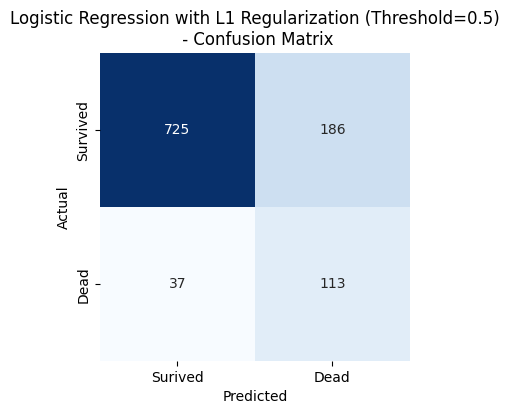

              precision    recall  f1-score   support

           0       0.95      0.80      0.87       911
           1       0.38      0.75      0.50       150

    accuracy                           0.79      1061
   macro avg       0.66      0.77      0.69      1061
weighted avg       0.87      0.79      0.82      1061



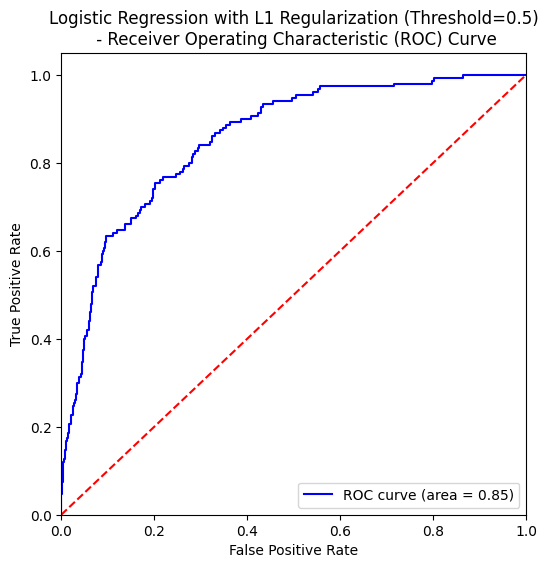

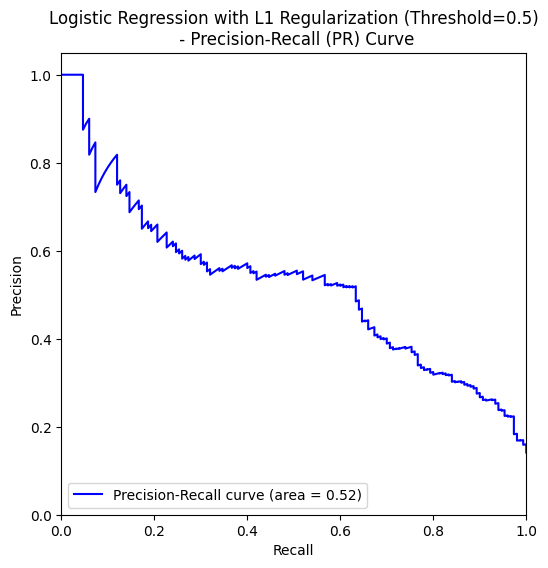

In [321]:
util.evaluate_classification_model(y_prob_test, 0.5, y_test, model_name='Logistic Regression with L1 Regularization')

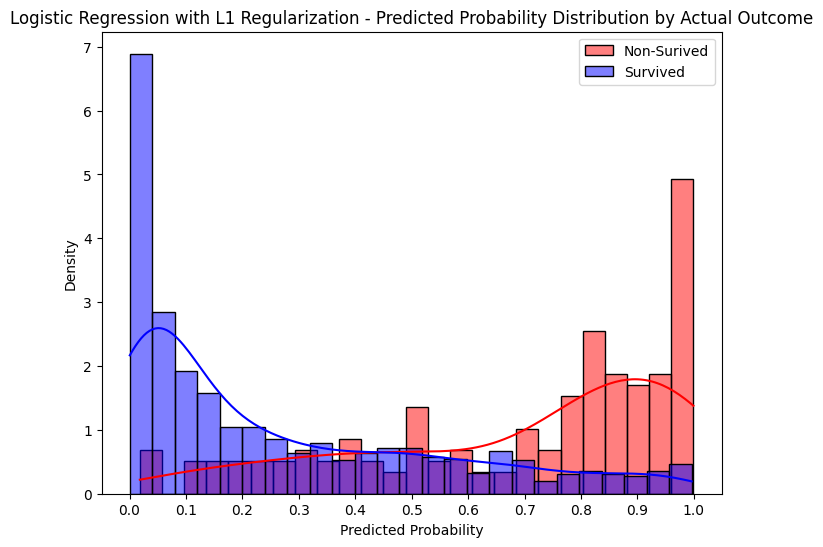

In [322]:
# Visualize Threshold Distribution
util.plot_threshold_distribution(y_prob_test, y_test, model_name='Logistic Regression with L1 Regularization')

In [323]:
util.threshold_analysis(y_prob_test, y_test, threshold_range=np.arange(0.3, 0.7, 0.01))

Threshold 0.300 -> Recall: 0.867, FPR: 0.338, Precisinon: 0.297
Threshold 0.310 -> Recall: 0.867, FPR: 0.333, Precisinon: 0.300
Threshold 0.320 -> Recall: 0.860, FPR: 0.330, Precisinon: 0.300
Threshold 0.330 -> Recall: 0.847, FPR: 0.324, Precisinon: 0.301
Threshold 0.340 -> Recall: 0.840, FPR: 0.312, Precisinon: 0.307
Threshold 0.350 -> Recall: 0.840, FPR: 0.307, Precisinon: 0.310
Threshold 0.360 -> Recall: 0.840, FPR: 0.296, Precisinon: 0.318
Threshold 0.370 -> Recall: 0.827, FPR: 0.288, Precisinon: 0.321
Threshold 0.380 -> Recall: 0.820, FPR: 0.286, Precisinon: 0.320
Threshold 0.390 -> Recall: 0.813, FPR: 0.282, Precisinon: 0.322
Threshold 0.400 -> Recall: 0.800, FPR: 0.277, Precisinon: 0.323
Threshold 0.410 -> Recall: 0.793, FPR: 0.266, Precisinon: 0.330
Threshold 0.420 -> Recall: 0.780, FPR: 0.262, Precisinon: 0.329
Threshold 0.430 -> Recall: 0.780, FPR: 0.256, Precisinon: 0.334
Threshold 0.440 -> Recall: 0.773, FPR: 0.251, Precisinon: 0.336
Threshold 0.450 -> Recall: 0.773, FPR: 0

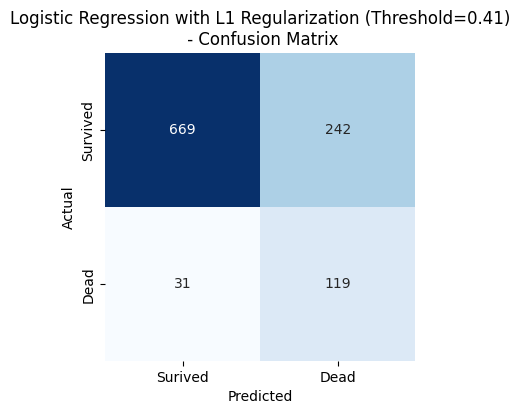

              precision    recall  f1-score   support

           0       0.96      0.73      0.83       911
           1       0.33      0.79      0.47       150

    accuracy                           0.74      1061
   macro avg       0.64      0.76      0.65      1061
weighted avg       0.87      0.74      0.78      1061



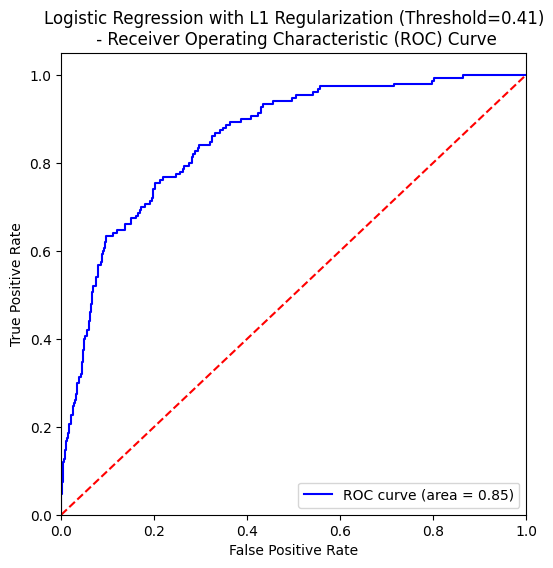

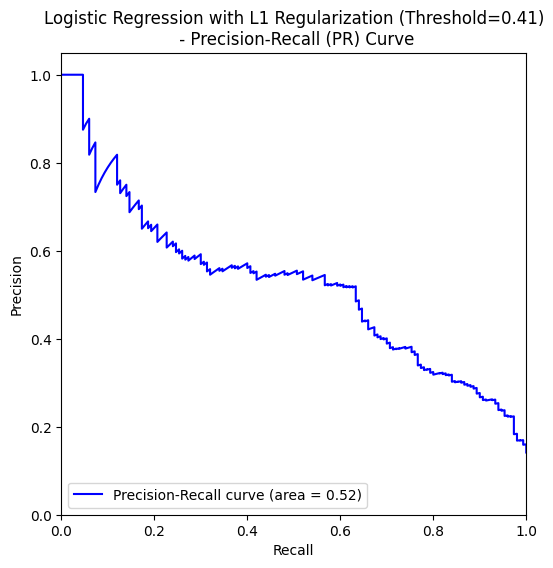

In [325]:

util.evaluate_classification_model(y_prob_test,0.410, y_test, model_name='Logistic Regression with L1 Regularization')

## Feature Importance

In [326]:
# Feature Importance from Logistic Regression with L1 Regularization
coef_df = pd.DataFrame({
    'feature': X_train.columns,
    'coef': logreg_l1.coef_.flatten()})
coef_df['abs_coef'] = coef_df['coef'].abs()
coef_df.sort_values('abs_coef', ascending=False, inplace=True)
print(coef_df)


              feature      coef  abs_coef
21           GCS_last -0.971454  0.971454
72         HCO3_first  0.594474  0.594474
104  MechVentDuration  0.575789  0.575789
109   RespRate_tested -0.570162  0.570162
58   NIDiasABP_median -0.566966  0.566966
..                ...       ...       ...
112        AST_tested  0.000000  0.000000
115    DiasABP_tested  0.000000  0.000000
114  Bilirubin_tested  0.000000  0.000000
110        ALP_tested  0.000000  0.000000
122     SysABP_tested  0.000000  0.000000

[125 rows x 3 columns]


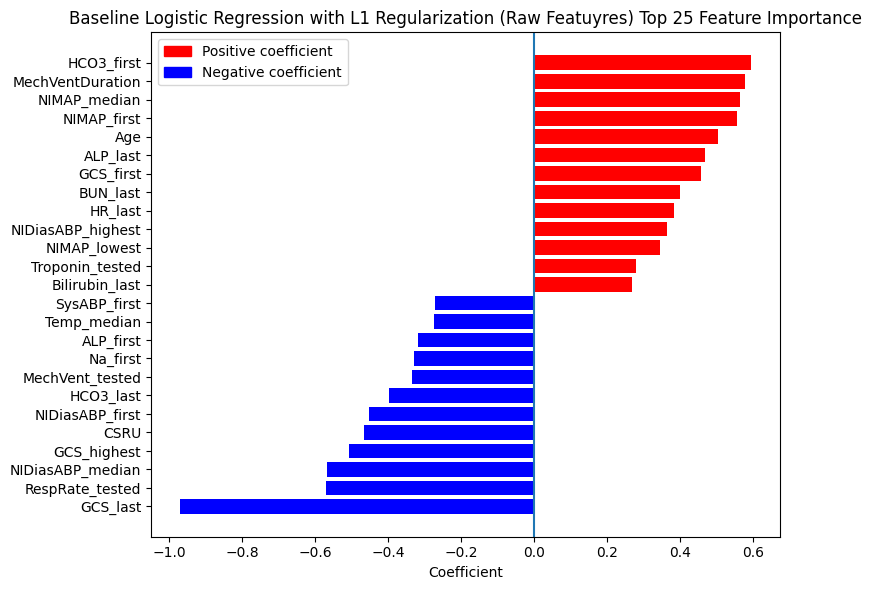

In [327]:
# Plot Top 25 Features
import utility as util
util.plot_top25_feature_importance(coef_df, model_name='Baseline Logistic Regression with L1 Regularization (Raw Featuyres)')

In [328]:
# Filter features that have zero coefficients
features_zero_coef = coef_df[coef_df['coef'] == 0]['feature'].tolist()
features_zero_coef.sort()
print('Number of features with zero coefficients:', len(features_zero_coef))
print('Features with zero coefficients:', features_zero_coef)

# Filter features with very low coefficients
features_low_coef = coef_df[coef_df['abs_coef'] <0.1]['feature'].tolist()
features_low_coef.sort()
print('Number of features with low coefficients:', len(features_low_coef))
print('Features with low coefficients:', features_low_coef)

Number of features with zero coefficients: 14
Features with zero coefficients: ['ALP_tested', 'ALT_last', 'AST_tested', 'Bilirubin_tested', 'DiasABP_tested', 'Glucose_highest', 'NIDiasABP_last', 'SICU', 'SaO2_median', 'SysABP_lowest', 'SysABP_tested', 'Temp_highest', 'WBC_last', 'Weight_first']
Number of features with low coefficients: 64
Features with low coefficients: ['ALP_tested', 'ALT_last', 'AST_last', 'AST_tested', 'Albumin_first', 'Albumin_last', 'Albumin_tested', 'BUN_first', 'Bilirubin_first', 'Bilirubin_tested', 'CCU', 'Cholesterol_tested', 'Creatinine_first', 'DiasABP_last', 'DiasABP_tested', 'FiO2_first', 'FiO2_last', 'GCS_lowest', 'Glucose_first', 'Glucose_highest', 'Glucose_lowest', 'Glucose_median', 'HCT_first', 'HCT_last', 'HR_first', 'HR_lowest', 'HR_median', 'Height', 'Height_tested', 'K_first', 'K_last', 'Lactate_first', 'Lactate_tested', 'MAP_first', 'MAP_highest', 'MAP_last', 'MAP_lowest', 'MAP_median', 'NIDiasABP_last', 'NIMAP_last', 'NISysABP_lowest', 'Na_last',

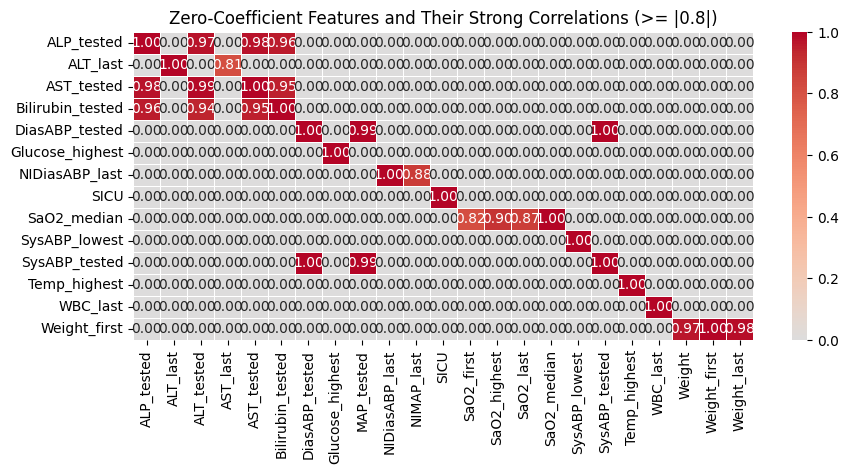

In [329]:
# Full correlation matrix
corr_matrix=X_train[sorted(X_train.columns)].corr()

# Columns where zero-coef features have |corr| >= 0.8
mask = (
    corr_matrix.loc[features_zero_coef, :].gt(0.8).any() |
    corr_matrix.loc[features_zero_coef, :].lt(-0.8).any()
)

correlated_features = corr_matrix.loc[features_zero_coef, mask]

# Mask weak correlations for cleaner visualization
corr_display = correlated_features.mask(
    (correlated_features < 0.8) & (correlated_features > -0.8)
)

# Heatmap
plt.figure(figsize=(10,4))
sns.heatmap(corr_display.fillna(0), annot=True, cmap='coolwarm', fmt=".2f", center=0, linewidths=0.5)
plt.title('Zero-Coefficient Features and Their Strong Correlations (>= |0.8|)')
plt.show()


In [330]:
# Find highly correlated pairs
threshold = 0.8
high_corr_pairs_idx = np.where(np.abs(corr_matrix) > threshold)

# Filter out duplicates and self-correlation
high_corr_pairs = [
    (corr_matrix.index[x], corr_matrix.columns[y], corr_matrix.iloc[x, y])
    for x, y in zip(*high_corr_pairs_idx) if x != y and x < y]

# Convert to DataFrame
high_corr_df = pd.DataFrame(high_corr_pairs, columns=["Feature_1", "Feature_2", "Correlation"])
high_corr_df = high_corr_df.sort_values(by="Correlation", ascending=False).reset_index(drop=True)

In [331]:
# Merge high correlation pairs with logistic regression coefficients
high_corr_df = high_corr_df.merge(coef_df.rename(columns={'feature': 'Feature_1', 'coef': 'Coef_1', 'abs_coef': 'Abs_Coef_1 '}), on='Feature_1')
high_corr_df = high_corr_df.merge(coef_df.rename(columns={'feature': 'Feature_2', 'coef': 'Coef_2', 'abs_coef': 'Abs_Coef_2 '}), on='Feature_2')
high_corr_df=high_corr_df.sort_values(by='Correlation', ascending=False)
high_corr_df=high_corr_df[['Feature_1','Feature_2','Correlation', 'Coef_1',   'Coef_2' ]].sort_values(['Feature_1','Feature_2'])

In [332]:
# Identify high-correlation pairs where at least one feature has a zero coefficient
print(high_corr_df[(high_corr_df.Coef_1==0) | (high_corr_df.Coef_2==0)])

         Feature_1         Feature_2  Correlation    Coef_1    Coef_2
7       ALP_tested        ALT_tested     0.974579  0.000000  0.121969
6       ALP_tested        AST_tested     0.976259  0.000000  0.000000
9       ALP_tested  Bilirubin_tested     0.958874  0.000000  0.000000
34        ALT_last          AST_last     0.812753  0.000000  0.038801
4       ALT_tested        AST_tested     0.990136  0.121969  0.000000
12      ALT_tested  Bilirubin_tested     0.943250  0.121969  0.000000
10      AST_tested  Bilirubin_tested     0.948201  0.000000  0.000000
2   DiasABP_tested        MAP_tested     0.993196  0.000000 -0.170883
1   DiasABP_tested     SysABP_tested     1.000000  0.000000  0.000000
3       MAP_tested     SysABP_tested     0.993196 -0.170883  0.000000
20  NIDiasABP_last        NIMAP_last     0.882597  0.000000 -0.024165
31      SaO2_first       SaO2_median     0.818672  0.020765  0.000000
17    SaO2_highest       SaO2_median     0.904757  0.095557  0.000000
23       SaO2_last  

## Baseline Model Summary

The L1-regularized logistic regression baseline model achieved an overall test accuracy of 79% with the default threshold set at 0.5, with an F1 score of 0.49, recall of 0.75, and precision of 0.37. Given the highly imbalanced nature of the ICU mortality dataset, this baseline model performs reasonably well in identifying non-survived patients, correctly capturing 75% (113/151) of deaths in the test set.

However, this performance comes at the cost of a high false positive rate. The model incorrectly flags 21% (193/929) of survived patients as non-survivors, and it also fails to identify 25% (38/151) of non-survived patients, predicitng them as survivors. This trade-off between recall and precision is expected in imbalanced clinical prediction tasks and highlights the need for further refinement beyond the baseline.

After threshold tuning, the model showed a modest improvement in recall for non-survived patients, reaching 0.81 (122/151). However, precision decreased to 0.34, and overall accuracy dropped slightly to 76%. The model still fails to correctly predict 19% (29/151) of deaths, underscoring the challenges of balancing sensitivity and specificity in clinical outcome prediction.

The L1-regularized model was selected as the baseline because it provides embedded feature selection, allowing us to identify features that contribute little predictive value due to redundancy or multicollinearity. Examination of the top 25 features by coefficient magnitude reveals both strongly positive and strongly negative coefficients, indicating features with substantial influence on mortality risk.

Notably, several clinical variables measured at different time points exhibit opposing coefficient directions. For example, GCS_first shows a positive association with mortality, while GCS_last shows a negative association, suggesting that temporal dynamics—such as patient deterioration or improvement over time—play an important role in outcome prediction. These observations motivate further exploration of temporal feature engineering.

In addition, the L1-regularized model assigns zero coefficients to six features, indicating that they do not contribute to the model’s predictions. Correlation analysis shows that five out of these six features are highly correlated with one or more retained features, reinforcing the role of L1 regularization in reducing feature redundancy.

In the next phase, we will further evaluate features using univariate statistical testing, reassess feature redundancy, and explore temporal feature engineering (e.g., first–last differences and ranges) to better capture clinically meaningful patterns and improve model performance.



# Feature Evaluation and Engineering

## ICU Lab Tests Categorized by Clinical Purpose

| **Clinical Purpose Category** | **Tests** |
|-------------------------------|-----------|
| **Liver Function** | ALP, ALT, AST, Bilirubin |
| **Kidney Function** | BUN, Creatinine |
| **Electrolytes** | Na, K, Mg |
| **Acid–Base / Metabolic** | HCO3, Lactate, pH |
| **Blood Gas / Respiratory** | PaCO2, PaO2, FiO2 |
| **Hematology** | HCT, Platelets, WBC |
| **Cardiac Markers** | TroponinI, TroponinT |
| **General Metabolic / Nutritional Status** | Albumin, Cholesterol |
| **Glucose Regulation** | Glucose |
| **Oxygenation / Perfusion** | SaO2 |
| **Vital Signs (Physiologic Measurements)** | HR, RespRate, Temp, SysABP, DiasABP, MAP, NISysABP, NIDiasABP, NIMAP |
| **Neurological Assessment** | GCS |
| **Ventilation / Respiratory Support** | MechVentStartTime, MechVentDuration, MechVentLast8Hour |
| **Renal Output** | UrineOutputSum |


## Feature Evaluation with Univariate Statistical Test

In [333]:
high_corr_df_zero_coef=high_corr_df[(high_corr_df.Coef_1==0) | (high_corr_df.Coef_2==0)]
print(high_corr_df_zero_coef)

         Feature_1         Feature_2  Correlation    Coef_1    Coef_2
7       ALP_tested        ALT_tested     0.974579  0.000000  0.121969
6       ALP_tested        AST_tested     0.976259  0.000000  0.000000
9       ALP_tested  Bilirubin_tested     0.958874  0.000000  0.000000
34        ALT_last          AST_last     0.812753  0.000000  0.038801
4       ALT_tested        AST_tested     0.990136  0.121969  0.000000
12      ALT_tested  Bilirubin_tested     0.943250  0.121969  0.000000
10      AST_tested  Bilirubin_tested     0.948201  0.000000  0.000000
2   DiasABP_tested        MAP_tested     0.993196  0.000000 -0.170883
1   DiasABP_tested     SysABP_tested     1.000000  0.000000  0.000000
3       MAP_tested     SysABP_tested     0.993196 -0.170883  0.000000
20  NIDiasABP_last        NIMAP_last     0.882597  0.000000 -0.024165
31      SaO2_first       SaO2_median     0.818672  0.020765  0.000000
17    SaO2_highest       SaO2_median     0.904757  0.095557  0.000000
23       SaO2_last  

In [334]:
# Merge with high correlation pairs with zero coefficients with Fisher's Exact Test results
high_corr_df_zero_coef_univarate=high_corr_df_zero_coef.merge(fisher_exact_test_df.reset_index().rename(columns={'Feature':'Feature_1', 'Odds Ratio':'Odds_Ratio_1', 'p-value':'p-value_1', 'Odds Ratio Interpretation':'interpret_odds_ratio_1'}), on='Feature_1', how='left')
high_corr_df_zero_coef_univarate=high_corr_df_zero_coef_univarate.merge(fisher_exact_test_df.reset_index().rename(columns={'Feature':'Feature_2', 'Odds Ratio':'Odds_Ratio_2', 'p-value':'p-value_2', 'Odds Ratio Interpretation':'interpret_odds_ratio_2'}), on='Feature_2', how='left')
high_corr_df_zero_coef_univarate

Feature_1         Feature_2  Correlation    Coef_1    Coef_2  \
0       ALP_tested        ALT_tested     0.974579  0.000000  0.121969   
1       ALP_tested        AST_tested     0.976259  0.000000  0.000000   
2       ALP_tested  Bilirubin_tested     0.958874  0.000000  0.000000   
3         ALT_last          AST_last     0.812753  0.000000  0.038801   
4       ALT_tested        AST_tested     0.990136  0.121969  0.000000   
5       ALT_tested  Bilirubin_tested     0.943250  0.121969  0.000000   
6       AST_tested  Bilirubin_tested     0.948201  0.000000  0.000000   
7   DiasABP_tested        MAP_tested     0.993196  0.000000 -0.170883   
8   DiasABP_tested     SysABP_tested     1.000000  0.000000  0.000000   
9       MAP_tested     SysABP_tested     0.993196 -0.170883  0.000000   
10  NIDiasABP_last        NIMAP_last     0.882597  0.000000 -0.024165   
11      SaO2_first       SaO2_median     0.818672  0.020765  0.000000   
12    SaO2_highest       SaO2_median     0.904757  0.095557  0.000000   
13       SaO2_last       SaO2_median     0.874215 -0.118080  0.000000   
14          Weight      Weight_first     0.967867 -0.149171  0.000000   
15    Weight_first       Weight_last     0.978571  0.000000 -0.130751   

    Odds_Ratio_1     p-value_1  Odds_Ratio_2     p-value_2  
0       2.233165  6.400730e-12      2.274365  2.036830e-12  
1       2.233165  6.400730e-12      2.297305  1.314464e-12  
2       2.233165  6.400730e-12      2.225031  7.178747e-12  
3            NaN           NaN           NaN           NaN  
4       2.274365  2.036830e-12      2.297305  1.314464e-12  
5       2.274365  2.036830e-12      2.225031  7.178747e-12  
6       2.297305  1.314464e-12      2.225031  7.178747e-12  
7       1.113194  4.484530e-01      1.119077  4.107746e-01  
8       1.113194  4.484530e-01      1.113194  4.484530e-01  
9       1.119077  4.107746e-01      1.113194  4.484530e-01  
10           NaN           NaN           NaN           NaN  
11           NaN           NaN           NaN           NaN  
12           NaN           NaN           NaN           NaN  
13           NaN           NaN           NaN           NaN  
14           NaN           NaN           NaN           NaN  
15           NaN           NaN           NaN           NaN

In [335]:
#Merge with Mann-Whitney U Test results
high_corr_df_zero_coef_univarate=high_corr_df_zero_coef_univarate.merge(mann_whitney_u_test_df.reset_index().rename(columns={'Feature':'Feature_1', 'U-statistic':'U_statistic_1', 'p-value':'mw_p_value_1', 'Median Survived':'Median_Survived_1', 'Median Non-Survived':'Median_Non_Survived_1', 'Effect Size':'Effect_Size_1', 'Effect Size Abs':'Effect_Size_Abs_1', 'Effect Size Interpretation':'Effect_Size_Interpretation_1'}), on='Feature_1', how='left')  
high_corr_df_zero_coef_univarate=high_corr_df_zero_coef_univarate.merge(mann_whitney_u_test_df.reset_index().rename(columns={'Feature':'Feature_2', 'U-statistic':'U_statistic_2', 'p-value':'mw_p_value_2', 'Median Survived':'Median_Survived_2', 'Median Non-Survived':'Median_Non_Survived_2', 'Effect Size':'Effect_Size_2', 'Effect Size Abs':'Effect_Size_Abs_2', 'Effect Size Interpretation':'Effect_Size_Interpretation_2'}), on='Feature_2', how='left')
high_corr_df_zero_coef_univarate     

Feature_1         Feature_2  Correlation    Coef_1    Coef_2  \
0       ALP_tested        ALT_tested     0.974579  0.000000  0.121969   
1       ALP_tested        AST_tested     0.976259  0.000000  0.000000   
2       ALP_tested  Bilirubin_tested     0.958874  0.000000  0.000000   
3         ALT_last          AST_last     0.812753  0.000000  0.038801   
4       ALT_tested        AST_tested     0.990136  0.121969  0.000000   
5       ALT_tested  Bilirubin_tested     0.943250  0.121969  0.000000   
6       AST_tested  Bilirubin_tested     0.948201  0.000000  0.000000   
7   DiasABP_tested        MAP_tested     0.993196  0.000000 -0.170883   
8   DiasABP_tested     SysABP_tested     1.000000  0.000000  0.000000   
9       MAP_tested     SysABP_tested     0.993196 -0.170883  0.000000   
10  NIDiasABP_last        NIMAP_last     0.882597  0.000000 -0.024165   
11      SaO2_first       SaO2_median     0.818672  0.020765  0.000000   
12    SaO2_highest       SaO2_median     0.904757  0.095557  0.000000   
13       SaO2_last       SaO2_median     0.874215 -0.118080  0.000000   
14          Weight      Weight_first     0.967867 -0.149171  0.000000   
15    Weight_first       Weight_last     0.978571  0.000000 -0.130751   

    Odds_Ratio_1     p-value_1  Odds_Ratio_2     p-value_2  U_statistic_1  \
0       2.233165  6.400730e-12      2.274365  2.036830e-12            NaN   
1       2.233165  6.400730e-12      2.297305  1.314464e-12            NaN   
2       2.233165  6.400730e-12      2.225031  7.178747e-12            NaN   
3            NaN           NaN           NaN           NaN       362867.5   
4       2.274365  2.036830e-12      2.297305  1.314464e-12            NaN   
5       2.274365  2.036830e-12      2.225031  7.178747e-12            NaN   
6       2.297305  1.314464e-12      2.225031  7.178747e-12            NaN   
7       1.113194  4.484530e-01      1.119077  4.107746e-01            NaN   
8       1.113194  4.484530e-01      1.113194  4.484530e-01            NaN   
9       1.119077  4.107746e-01      1.113194  4.484530e-01            NaN   
10           NaN           NaN           NaN           NaN       414437.5   
11           NaN           NaN           NaN           NaN       393752.0   
12           NaN           NaN           NaN           NaN       397117.5   
13           NaN           NaN           NaN           NaN       401787.5   
14           NaN           NaN           NaN           NaN       422073.5   
15           NaN           NaN           NaN           NaN       429491.0   

    ...  Effect_Size_1  Effect_Size_Abs_1  Effect_Size_Interpretation_1  \
0   ...            NaN                NaN                           NaN   
1   ...            NaN                NaN                           NaN   
2   ...            NaN                NaN                           NaN   
3   ...       0.025626           0.025626                    Negligible   
4   ...            NaN                NaN                           NaN   
5   ...            NaN                NaN                           NaN   
6   ...            NaN                NaN                           NaN   
7   ...            NaN                NaN                           NaN   
8   ...            NaN                NaN                           NaN   
9   ...            NaN                NaN                           NaN   
10  ...      -0.112850           0.112850                         Small   
11  ...      -0.057305           0.057305                    Negligible   
12  ...      -0.066342           0.066342                    Negligible   
13  ...      -0.078882           0.078882                    Negligible   
14  ...      -0.133354           0.133354                         Small   
15  ...      -0.153272           0.153272                         Small   

    U_statistic_2  mw_p_value_2 Median_Survived_2  Median_Non_Survived_2  \
0             NaN           NaN               NaN                    NaN   
1             NaN           N

In [336]:
# Remove DiasABP_tested and SysABP_tested pairs due to high correlation low discrimative power
X_train=X_train.drop(columns=['DiasABP_tested','SysABP_tested'], axis=1)
X_test=X_test.drop(columns=['DiasABP_tested','SysABP_tested'], axis=1)

### Feature Reduction Based on Correlation and Univariate Tests

After reviewing the highly correlated feature pairs and examining the coefficients from the L1-regularized baseline model, we further cross-checked with the univariate statistical tests.  

Features such as **DiasABP_tested** and **SysABP_tested** were found to be:

- **Highly correlated** to each other (correlation = 1).  
- **Non-significant** in the univariate analysis, with p-value = 0.06.  
- **Weakly associated** with the outcome, having a low positive odds ratio of 1.27.  
- **Highly correlated** with **MAP_tested**, which has a significant p-value (< 0.05) and stronger discriminative power.  

Given their weak predictive signal and redundancy, **DiasABP_tested** and **SysABP_tested** are **removed** from the feature set to reduce potential noise and improve model interpretability.


## Feature Engineering

In [337]:
# Additional Clinical Features for BMI and BUN/Creatinine Ratio
def clinical_feature(df,new_column, column1, column2):
    if column2=='Height':
        df[new_column + '_first'] = df[column1 + '_first'] / df[column2]
        df[new_column + '_last'] = df[column1 + '_last'] / df[column2]
    else:
        df[new_column + '_first'] = df[column1 + '_first'] / df[column2 + '_first']
        df[new_column + '_last'] = df[column1 + '_last'] / df[column2 + '_last']
    return df
X_train = clinical_feature(X_train, 'BUN_Creatinine_Ratio', 'BUN', 'Creatinine')
X_test = clinical_feature(X_test, 'BUN_Creatinine_Ratio', 'BUN', 'Creatinine')
X_train = clinical_feature(X_train, 'BMI', 'Weight', 'Height')
X_test = clinical_feature(X_test, 'BMI', 'Weight', 'Height')

In [338]:
# Temporal Feature Engineering
def feature_engineer_temporal(df,column_name, high_low=False):
    df[column_name+'_delta'] = df[column_name+'_last'] - df[column_name+'_first']
    df[column_name+'_ratio'] = df[column_name+'_last'] / df[column_name+'_first']
    if high_low:
        df[column_name+'_range'] = df[column_name+'_highest'] - df[column_name+'_lowest']
    return df

In [339]:
for name in ['ALP', 'ALT', 'AST', 'Albumin', 'BUN','Bilirubin', 'Creatinine','DiasABP', 'FiO2','GCS','Glucose', 'HCO3','HCT','HR','K','Lactate', 'MAP', 'Mg','NIDiasABP','NIMAP','NISysABP','Na','PaCO2','Platelets','SaO2', 'SysABP','Temp', 'Weight', 'pH','BMI','BUN_Creatinine_Ratio']:
    high_low = True if name in ['DiasABP', 'GCS', 'Glucose','HR', 'MAP','NIDiasABP','NIMAP','NISysABP','SaO2', 'SysABP','Temp'] else False
    X_train = feature_engineer_temporal(X_train, name, high_low)
    X_test = feature_engineer_temporal(X_test, name, high_low)

In [340]:
# Get the temporal feature columns
new_features = [col for col in X_train.columns if col.endswith('_delta') or col.endswith('_ratio') or col.endswith('_range')]+['BMI_first','BMI_last','BUN_Creatinine_Ratio_first','BUN_Creatinine_Ratio_last']

In [341]:
train_df_FeatureEngineer=pd.concat([X_train, y_train], axis=1)

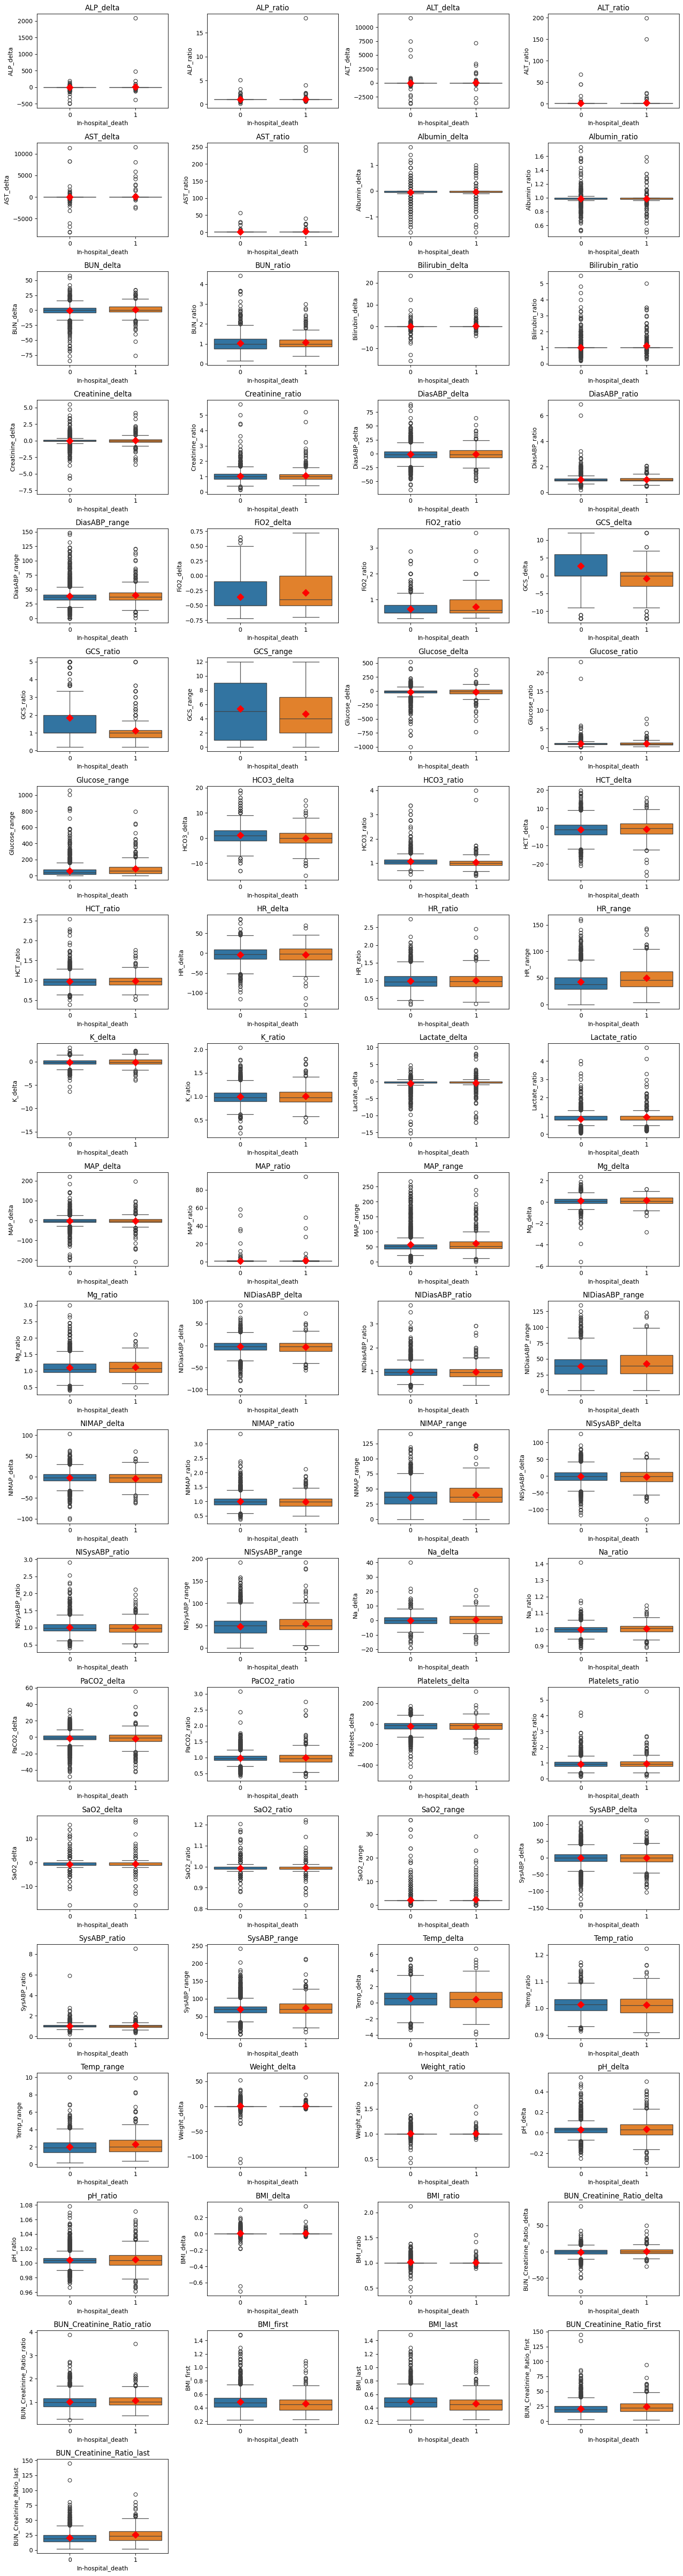

In [342]:
# boxplots for temporal features
util.plot_boxplots(train_df_FeatureEngineer, new_features, 'In-hospital_death')

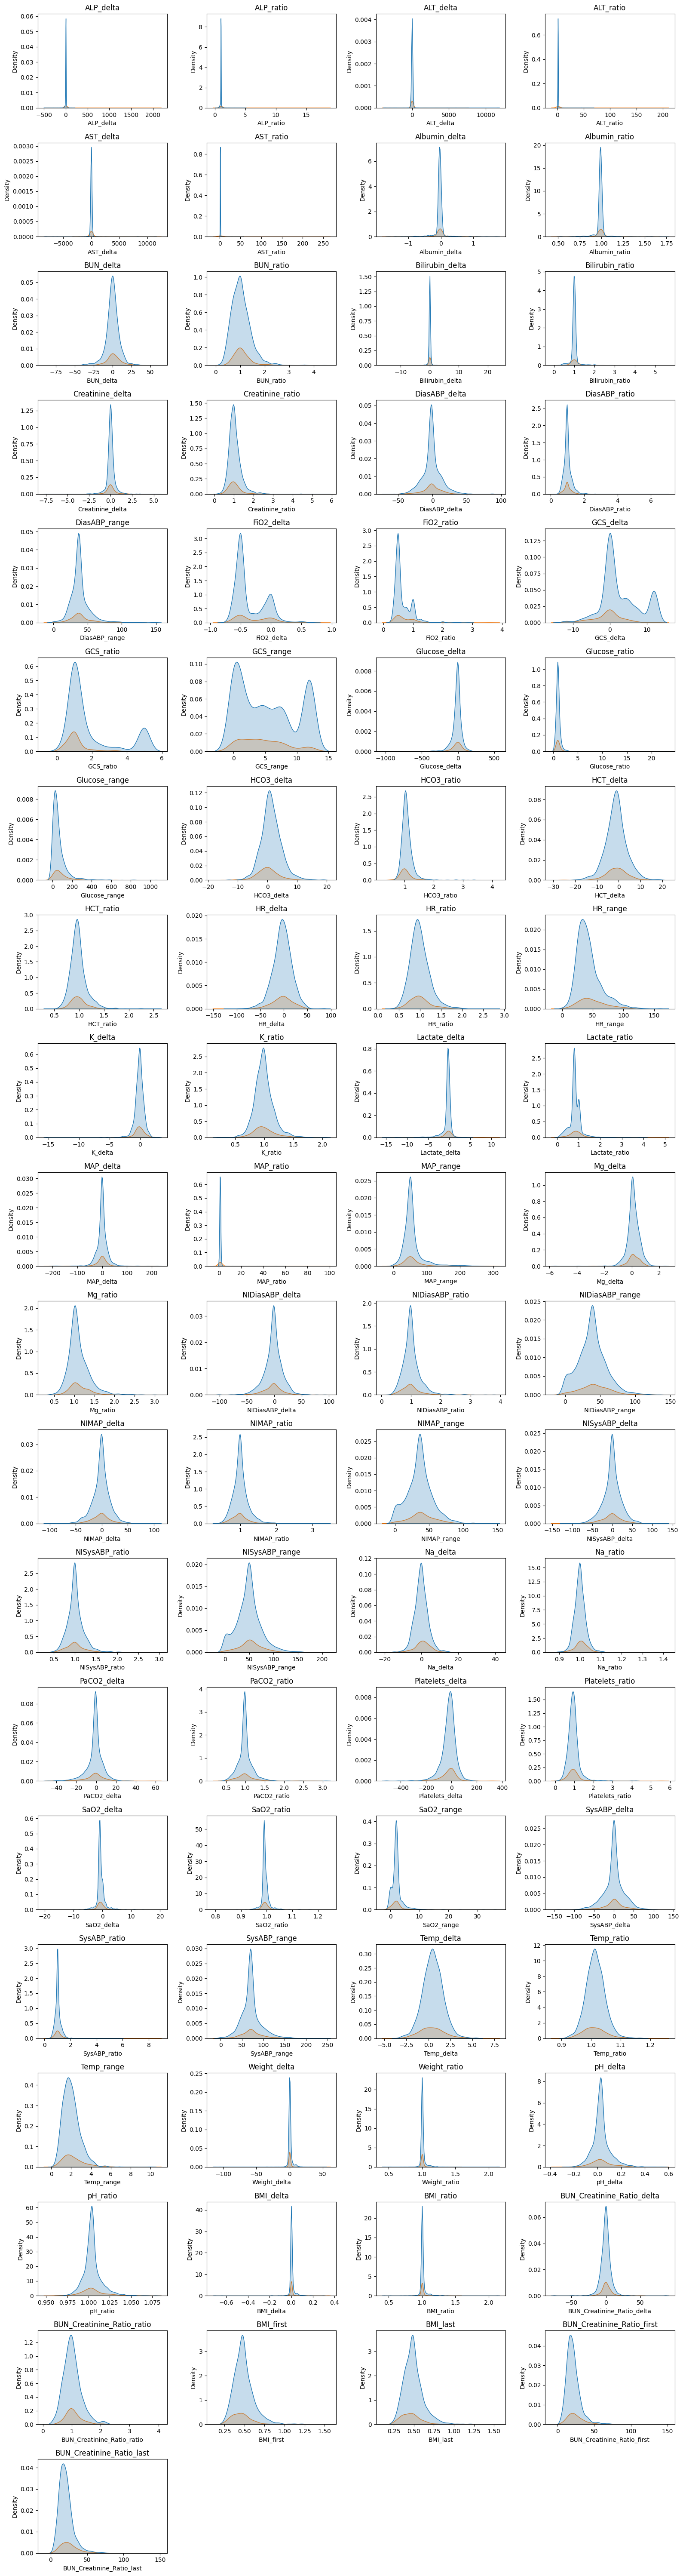

In [343]:
# KDE plots for temporal features
util.plot_kde_plots(train_df_FeatureEngineer, new_features, 'In-hospital_death')

In [344]:
#Call the mann_whitney_u_test function
mw_newFeature_df=util.mann_whitney_u_test(train_df_FeatureEngineer, outcome_col='In-hospital_death', numeric_cols=new_features)

# Sort by p-value and filter significant features
mw_newFeature_df=mw_newFeature_df.sort_values(by='p-value', ascending=True)
    
mw_newFeature_df['Effect Size Interpretation'] = mw_newFeature_df['Effect Size Abs'].apply(util.interpret_effect_size)
mw_newFeature_df

U-statistic       p-value  Median Survived  \
Feature                                                                 
GCS_delta                     504943.5  5.830584e-28         0.000000   
GCS_ratio                     500422.5  3.533236e-26         1.000000   
Glucose_range                 283522.5  7.270397e-13        39.000000   
BUN_Creatinine_Ratio_last     283758.5  8.358901e-13        19.000000   
HCO3_delta                    449802.0  3.417030e-10         1.000000   
...                                ...           ...              ...   
HR_ratio                      371798.0  9.605780e-01         0.965517   
K_ratio                       371927.5  9.688920e-01         0.977273   
K_delta                       372645.5  9.849223e-01        -0.100000   
MAP_ratio                     372297.5  9.926300e-01         0.987805   
HR_delta                      372420.5  9.994204e-01        -3.000000   

                           Median Non-Survived  Effect Size  Effect Size Abs  \
Feature                                                                        
GCS_delta                             0.000000    -0.355877         0.355877   
GCS_ratio                             1.000000    -0.343737         0.343737   
Glucose_range                        60.000000     0.238684         0.238684   
BUN_Creatinine_Ratio_last            23.333333     0.238050         0.238050   
HCO3_delta                            0.000000    -0.207811         0.207811   
...                                        ...          ...              ...   
HR_ratio                              0.977778     0.001646         0.001646   
K_ratio                               0.975610     0.001298         0.001298   
K_delta                              -0.100000    -0.000630         0.000630   
MAP_ratio                             0.987805     0.000305         0.000305   
HR_delta                             -2.000000    -0.000026         0.000026   

                          Effect Size Interpretation  
Feature                                               
GCS_delta                                     Medium  
GCS_ratio                                     Medium  
Glucose_range                                  Small  
BUN_Creatinine_Ratio_last                      Small  
HCO3_delta                                     Small  
...                                              ...  
HR_ratio                                  Negligible  
K_ratio                                   Negligible  
K_delta                                   Negligible  
MAP_ratio                                 Negligible  
HR_delta                                  Negligible  

[77 rows x 7 columns]

In [345]:
mw_newFeature_df_nonSignificant= mw_newFeature_df[mw_newFeature_df['p-value'] >= 0.05]
mw_newFeature_df_nonSignificant


U-statistic   p-value  Median Survived  Median Non-Survived  \
Feature                                                                         
GCS_range            395299.5  0.062325         5.000000             4.000000   
Temp_ratio           394550.5  0.073999         1.013550             1.010870   
Temp_delta           393839.5  0.083713         0.500000             0.400000   
NIMAP_ratio          392748.5  0.100439         0.984870             0.984870   
BMI_ratio            388609.0  0.105154         1.000000             1.000000   
Weight_ratio         388608.0  0.105175         1.000000             1.000000   
BMI_delta            388595.0  0.105460         0.000000             0.000000   
Weight_delta         388490.0  0.107724         0.000000             0.000000   
NIMAP_delta          391701.0  0.119199        -1.165000            -1.165000   
NIDiasABP_ratio      389434.5  0.169086         0.966102             0.966102   
SaO2_delta           358111.0  0.183287        -1.000000            -1.000000   
NIDiasABP_delta      387648.5  0.218140        -2.000000            -2.000000   
DiasABP_range        357537.0  0.222705        37.000000            37.000000   
HCT_ratio            357332.0  0.223672         0.959943             0.978328   
HCT_delta            357425.0  0.226536        -1.300000            -0.700000   
Glucose_ratio        358529.0  0.262545         0.927178             0.945205   
SaO2_ratio           360380.5  0.275169         0.989796             0.989796   
NISysABP_ratio       385421.0  0.293316         0.991525             0.991525   
NISysABP_delta       385052.5  0.307016        -1.000000            -1.000000   
DiasABP_delta        360210.0  0.317297        -2.000000            -2.000000   
DiasABP_ratio        360882.0  0.345891         0.967742             0.967742   
Glucose_delta        360865.0  0.351398        -9.000000            -8.000000   
PaCO2_ratio          381333.5  0.468463         0.975000             0.975000   
Creatinine_ratio     380156.5  0.530073         1.000000             1.000000   
SysABP_ratio         366267.5  0.614736         1.000000             1.000000   
SysABP_delta         366340.0  0.618910         0.000000             0.000000   
Creatinine_delta     378089.0  0.645016         0.000000             0.000000   
Platelets_ratio      367522.5  0.693240         0.911975             0.913876   
PaCO2_delta          377187.0  0.697064        -1.000000            -1.000000   
pH_delta             376618.0  0.731967         0.030000             0.030000   
Platelets_delta      376329.5  0.751857       -16.000000           -14.000000   
pH_ratio             376072.5  0.766103         1.004065             1.004065   
SaO2_range           370626.5  0.868736         2.000000             2.000000   
MAP_delta            371194.0  0.920652        -1.000000            -1.000000   
HR_ratio             371798.0  0.960578         0.965517             0.977778   
K_ratio              371927.5  0.968892         0.977273             0.975610   
K_delta              372645.5  0.984922        -0.100000            -0.100000   
MAP_ratio            372297.5  0.992630         0.987805             0.987805   
HR_delta             372420.5  0.999420        -3.000000            -2.000000   

                  Effect Size  Effect Size Abs Effect Size Interpretation  
Feature                                                                    
GCS_range           -0.061460         0.061460                 Negligible  
Temp_ratio          -0.059449         0.059449                 Negligible  
Temp_delta          -0.057540         0.057540                 Negligible  
NIMAP_ratio         -0.054610         0.054610                 Negligible  
BMI_ratio           -0.043495         0.043495                 Negligible  
Weight_ratio        -0.043492         0.043492                 Negligible  
BMI_delta           -0.043457         0.043457                 Negligible  
Weight_delta

In [346]:
mw_newFeature_df_significant = mw_newFeature_df[mw_newFeature_df['p-value'] < 0.05]
mw_newFeature_df_significant

U-statistic       p-value  Median Survived  \
Feature                                                                  
GCS_delta                      504943.5  5.830584e-28         0.000000   
GCS_ratio                      500422.5  3.533236e-26         1.000000   
Glucose_range                  283522.5  7.270397e-13        39.000000   
BUN_Creatinine_Ratio_last      283758.5  8.358901e-13        19.000000   
HCO3_delta                     449802.0  3.417030e-10         1.000000   
HCO3_ratio                     447299.0  1.421771e-09         1.043478   
HR_range                       301573.5  1.080650e-08        38.000000   
BUN_Creatinine_Ratio_first     301855.5  1.239031e-08        19.576923   
FiO2_delta                     316346.5  1.993522e-06        -0.500000   
BMI_last                       430766.5  2.477598e-06         0.484136   
FiO2_ratio                     319411.5  6.760723e-06         0.500000   
BMI_first                      428056.5  7.079764e-06         0.475911   
Lactate_ratio                  319929.0  8.592883e-06         0.789474   
Na_delta                       317905.0  9.933323e-06         0.000000   
Na_ratio                       319563.0  1.929046e-05         1.000000   
AST_ratio                      325068.5  2.111074e-05         0.954545   
AST_delta                      325862.5  2.795315e-05        -2.000000   
Lactate_delta                  330499.0  3.678661e-04        -0.400000   
Albumin_delta                  334180.0  4.342913e-04        -0.050000   
NISysABP_range                 328952.0  4.453535e-04        50.000000   
Bilirubin_delta                343984.5  4.591885e-04         0.000000   
Albumin_ratio                  334503.5  4.856705e-04         0.983051   
Bilirubin_ratio                344397.5  5.552316e-04         1.000000   
NIDiasABP_range                330167.5  6.400920e-04        39.000000   
NIMAP_range                    334125.5  1.985167e-03        36.495000   
Temp_range                     335688.0  3.030534e-03         1.900000   
BUN_Creatinine_Ratio_ratio     336884.0  4.143693e-03         0.989798   
BUN_Creatinine_Ratio_delta     340729.5  1.056770e-02        -0.182753   
ALT_delta                      350839.5  1.059256e-02         0.000000   
ALT_ratio                      350855.5  1.065076e-02         1.000000   
BUN_delta                      342343.0  1.513544e-02         0.000000   
SysABP_range                   344052.0  2.023511e-02        70.000000   
BUN_ratio                      343946.0  2.157881e-02         1.000000   
Mg_delta                       344525.5  2.404705e-02         0.100000   
MAP_range                      345578.5  2.802984e-02        51.000000   
ALP_ratio                      390822.5  2.831803e-02         1.000000   
ALP_delta                      390768.5  2.878449e-02         0.000000   
Mg_ratio                       347619.5  4.501007e-02         1.052632   

                            Median Non-Survived  Effect Size  Effect Size Abs  \
Feature                                                                         
GCS_delta                              0.000000    -0.355877         0.355877   
GCS_ratio                              1.000000    -0.343737         0.343737   
Glucose_range                         60.000000     0.238684         0.238684   
BUN_Creatinine_Ratio_last             23.333333     0.238050         0.238050   
HCO3_delta                             0.000000    -0.207811         0.207811   
HCO3_ratio                             1.000000    -0.201090         0.201090   
HR_range                              46.000000     0.190213         0.190213   
BUN_Creatinine_Ratio_first            22.500000     0.189456         0.189456   
FiO2_delta                            -0.400000     0.150545         0.150545   
BMI_last                               0.452409    -0.156696         0.156696   
FiO2_ratio                             0.600000     0.142315         0.142315   
BMI_first     

In [347]:
# Remove temporal features with no significant difference
drop_new_features = mw_newFeature_df_nonSignificant.index.tolist()
print('Drop temporal features with no significant difference:', drop_new_features)
X_train=X_train.drop(columns=drop_new_features, axis=1)
X_test=X_test.drop(columns=drop_new_features, axis=1)

Drop temporal features with no significant difference: ['GCS_range', 'Temp_ratio', 'Temp_delta', 'NIMAP_ratio', 'BMI_ratio', 'Weight_ratio', 'BMI_delta', 'Weight_delta', 'NIMAP_delta', 'NIDiasABP_ratio', 'SaO2_delta', 'NIDiasABP_delta', 'DiasABP_range', 'HCT_ratio', 'HCT_delta', 'Glucose_ratio', 'SaO2_ratio', 'NISysABP_ratio', 'NISysABP_delta', 'DiasABP_delta', 'DiasABP_ratio', 'Glucose_delta', 'PaCO2_ratio', 'Creatinine_ratio', 'SysABP_ratio', 'SysABP_delta', 'Creatinine_delta', 'Platelets_ratio', 'PaCO2_delta', 'pH_delta', 'Platelets_delta', 'pH_ratio', 'SaO2_range', 'MAP_delta', 'HR_ratio', 'K_ratio', 'K_delta', 'MAP_ratio', 'HR_delta']


In [348]:
# Remove static features that is patient specific
patient_specific_features=['Weight','Weight_first','Weight_last','Height']
X_train=X_train.drop(columns=patient_specific_features, axis=1)
X_test=X_test.drop(columns=patient_specific_features, axis=1)

In [349]:
# Add Number of Kidney Panels Tests Feature
X_train['Number_Kidney_Panels_Tested'] = X_train[['ALT_tested', 'ALP_tested','AST_tested','Bilirubin_tested']].sum(axis=1).astype(int)
print('Train Data:', X_train['Number_Kidney_Panels_Tested'].value_counts())

X_test['Number_Kidney_Panels_Tested'] = X_test[['ALT_tested', 'ALP_tested','AST_tested','Bilirubin_tested']].sum(axis=1).astype(int)
print('Test Data:', X_test['Number_Kidney_Panels_Tested'].value_counts())

Train Data: Number_Kidney_Panels_Tested
0    1362
4    1033
3      31
1      27
2      20
Name: count, dtype: int64
Test Data: Number_Kidney_Panels_Tested
0    577
4    442
1     18
3     17
2      7
Name: count, dtype: int64


## Feature Evaluation and Engineering Summary

### 1. Highly Correlated and Redundant Features
After reviewing highly correlated feature pairs, examining L1-regularized baseline model coefficients, and cross-checking with univariate statistical tests:

- **DiasABP_tested** and **SysABP_tested** were found to be:  
  - **Perfectly correlated** (correlation = 1)  
  - **Non-significant** in univariate analysis (p-value = 0.06)  
  - **Weakly associated** with the outcome (odds ratio = 1.27)  
  - **Highly correlated** with **MAP_tested**, which shows significant predictive power (p-value < 0.05)  

Given their weak signal and redundancy, **DiasABP_tested** and **SysABP_tested** were **removed** from the feature set to reduce noise and improve model interpretability.

### 2. Temporal Feature Engineering
Features capturing ICU measurements over time (first, last, highest, lowest) were engineered to capture:

- **Change (delta):** last − first measurement  
- **Ratio:** last ÷ first measurement  
- **Range:** highest − lowest measurement  

Mann–Whitney U tests were performed to evaluate distribution differences between survived and non-survived patients and assess their discriminative power. Features that are **non-significant (p-value > 0.05) with negligible effect size** were excluded, as these additional features could introduce noise and reduce model interpretability.

### 3. Aggregated Liver Panel Feature
As liver panel tests (ALP, ALT, AST, Bilirubin) were highly correlated, a new feature was created to summarize the **total number of liver tests performed** during the ICU stay.  



# Logistic Model with New Features

In [358]:
# Features scaling
scaler = StandardScaler()
X_train_scaled=scaler.fit_transform(X_train)
X_test_scaled=scaler.transform(X_test)


# Add the feature names back to scaled data
X_train_scaled_df=pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled_df=pd.DataFrame(X_test_scaled, columns=X_test.columns)

In [351]:
# Logistic Model with L1 Regularization
logreg_l1_m2 = LogisticRegression(penalty='l1', solver='liblinear', random_state=42, class_weight='balanced',max_iter=1000)
logreg_l1_m2.fit(X_train_scaled, y_train)

LogisticRegression(class_weight='balanced', max_iter=1000, penalty='l1',
                   random_state=42, solver='liblinear')

In [352]:
print('Number of iterations:', logreg_l1_m2.n_iter_[0])

Number of iterations: 17


In [353]:
# Predictions Probability
y_prob_test2=logreg_l1_m2.predict_proba(X_test_scaled)[:,1]

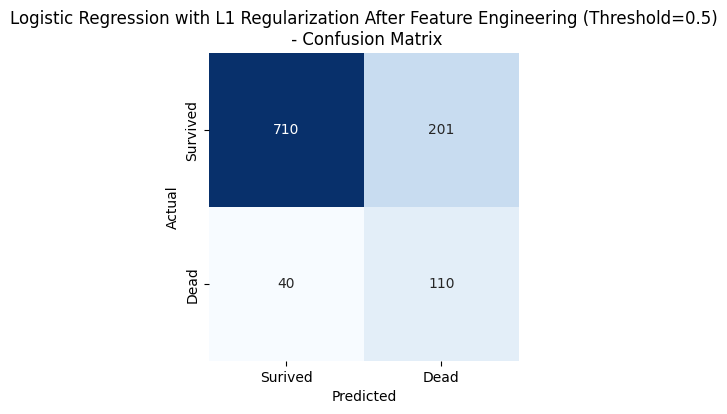

              precision    recall  f1-score   support

           0       0.95      0.78      0.85       911
           1       0.35      0.73      0.48       150

    accuracy                           0.77      1061
   macro avg       0.65      0.76      0.67      1061
weighted avg       0.86      0.77      0.80      1061



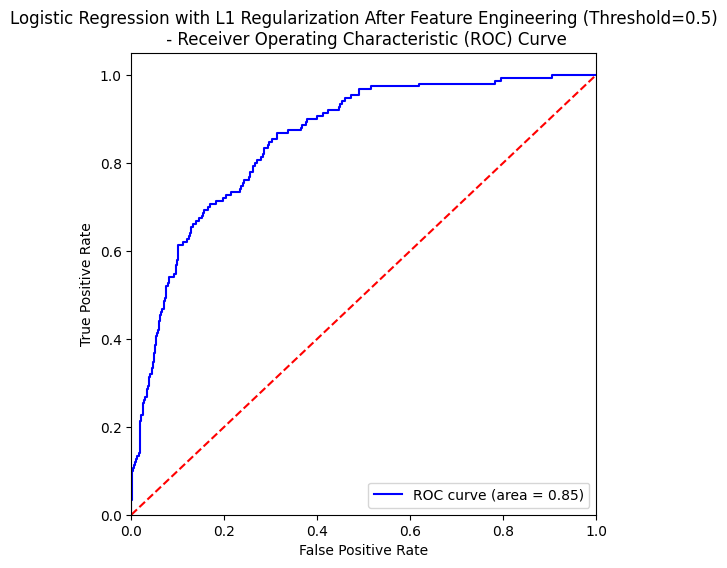

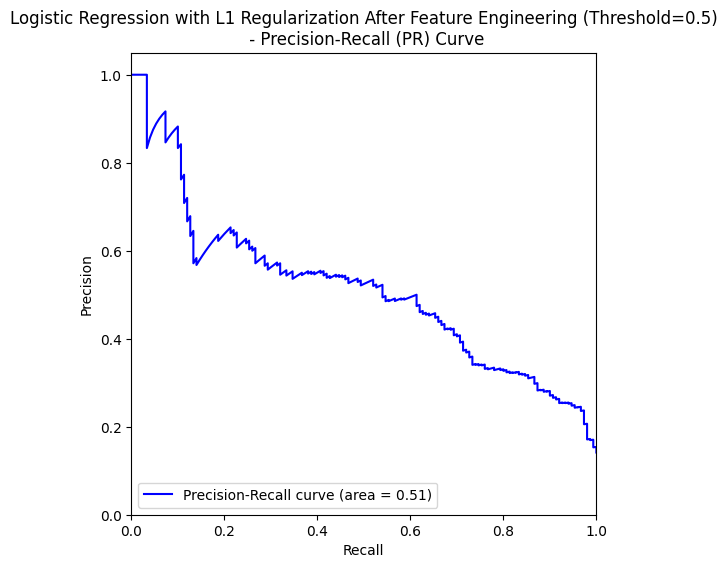

In [354]:
util.evaluate_classification_model(y_prob_test2, 0.5, y_test, model_name='Logistic Regression with L1 Regularization After Feature Engineering')

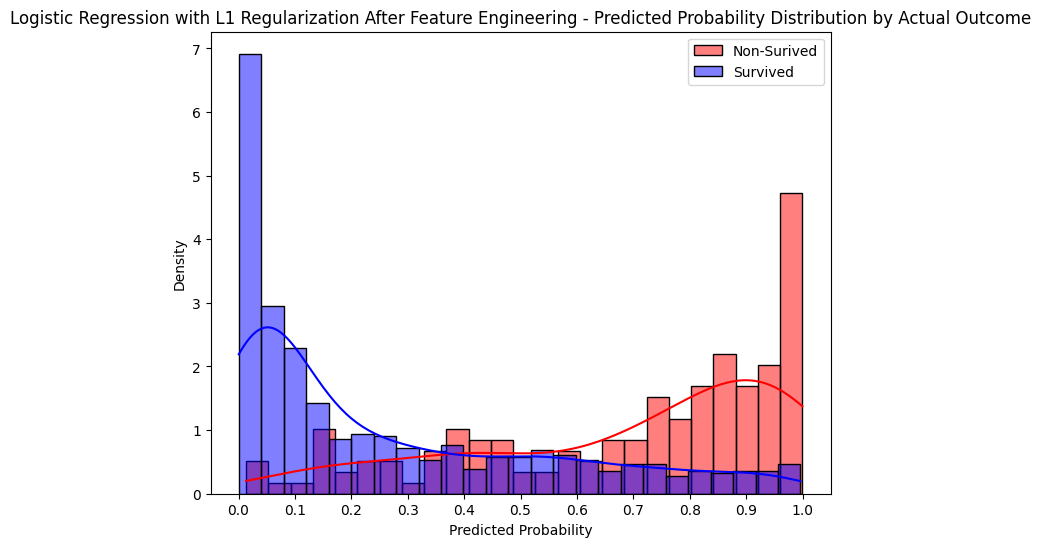

In [359]:
# Visualize Threshold Distribution
util.plot_threshold_distribution(y_prob_test2, y_test, model_name='Logistic Regression with L1 Regularization After Feature Engineering')

In [360]:
#Threshold Analysis
util.threshold_analysis(y_prob_test2, y_test, threshold_range=np.arange(0.2, 0.725, 0.01))

Threshold 0.200 -> Recall: 0.920, FPR: 0.424, Precisinon: 0.263
Threshold 0.210 -> Recall: 0.913, FPR: 0.417, Precisinon: 0.265
Threshold 0.220 -> Recall: 0.907, FPR: 0.407, Precisinon: 0.268
Threshold 0.230 -> Recall: 0.900, FPR: 0.400, Precisinon: 0.271
Threshold 0.240 -> Recall: 0.900, FPR: 0.387, Precisinon: 0.277
Threshold 0.250 -> Recall: 0.900, FPR: 0.379, Precisinon: 0.281
Threshold 0.260 -> Recall: 0.887, FPR: 0.370, Precisinon: 0.283
Threshold 0.270 -> Recall: 0.873, FPR: 0.362, Precisinon: 0.284
Threshold 0.280 -> Recall: 0.873, FPR: 0.350, Precisinon: 0.291
Threshold 0.290 -> Recall: 0.873, FPR: 0.349, Precisinon: 0.292
Threshold 0.300 -> Recall: 0.873, FPR: 0.342, Precisinon: 0.296
Threshold 0.310 -> Recall: 0.867, FPR: 0.333, Precisinon: 0.300
Threshold 0.320 -> Recall: 0.867, FPR: 0.322, Precisinon: 0.307
Threshold 0.330 -> Recall: 0.867, FPR: 0.314, Precisinon: 0.312
Threshold 0.340 -> Recall: 0.853, FPR: 0.310, Precisinon: 0.312
Threshold 0.350 -> Recall: 0.853, FPR: 0

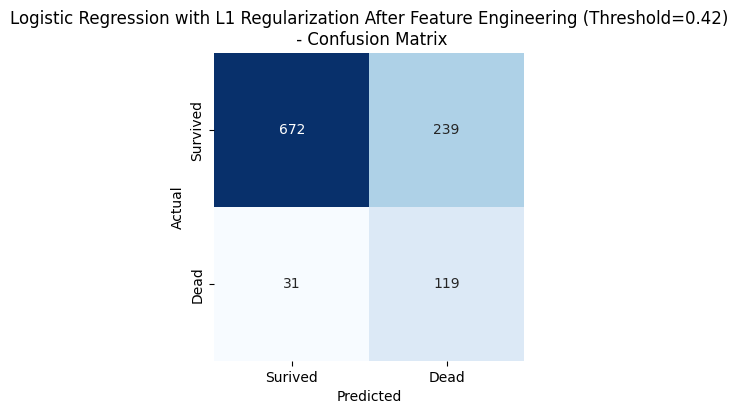

              precision    recall  f1-score   support

           0       0.96      0.74      0.83       911
           1       0.33      0.79      0.47       150

    accuracy                           0.75      1061
   macro avg       0.64      0.77      0.65      1061
weighted avg       0.87      0.75      0.78      1061



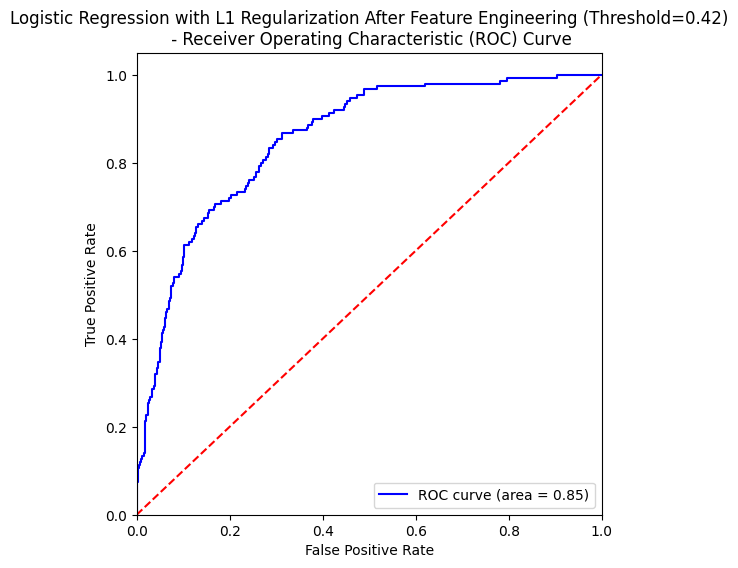

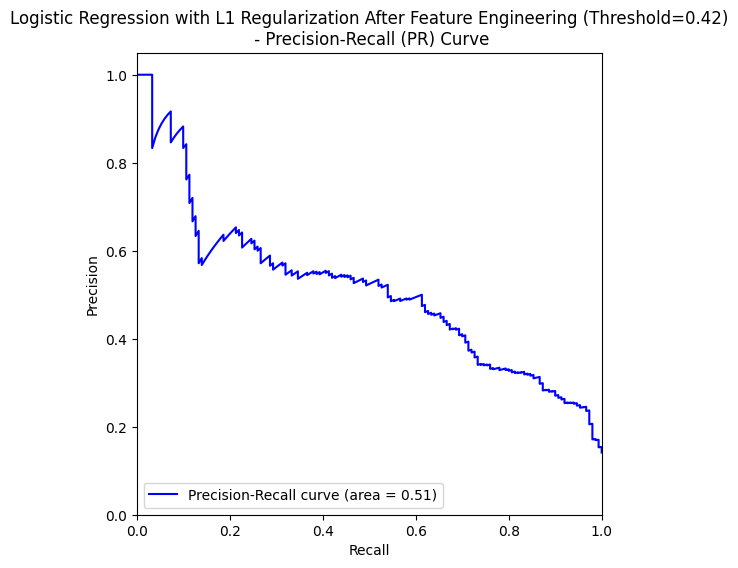

In [361]:
util.evaluate_classification_model(y_prob_test2, 0.42, y_test, model_name='Logistic Regression with L1 Regularization After Feature Engineering')

## Feature Importance After Feature Engineering

In [362]:
# Feature Importance from Logistic Regression with L1 Regularization
coef_df_m2 = pd.DataFrame({
    'feature': X_train.columns,
    'coef': logreg_l1_m2.coef_.flatten()})
coef_df_m2['abs_coef'] = coef_df_m2['coef'].abs()
coef_df_m2.sort_values('abs_coef', ascending=False, inplace=True)

In [363]:
coef_df_m2.head(25)

feature      coef  abs_coef
137          GCS_delta -0.766116  0.766116
124          ALP_ratio -0.652901  0.652901
100   MechVentDuration  0.629052  0.629052
13         NIMAP_first  0.592417  0.592417
41         GCS_highest -0.591789  0.591789
19            GCS_last -0.582121  0.582121
123          ALP_delta  0.558848  0.558848
105    RespRate_tested -0.556916  0.556916
56    NIDiasABP_median -0.516517  0.516517
2                  Age  0.504467  0.504467
57        NIMAP_median  0.495810  0.495810
12     NIDiasABP_first -0.466720  0.466720
5                 CSRU -0.464978  0.464978
148    NIDiasABP_range  0.435599  0.435599
21             HR_last  0.401739  0.401739
128          AST_ratio  0.359678  0.359678
138          GCS_ratio  0.318469  0.318469
140         HCO3_delta -0.285442  0.285442
101  MechVentLast8Hour -0.282414  0.282414
103    Troponin_tested  0.280879  0.280879
147           Mg_ratio -0.278317  0.278317
61         Temp_median -0.271732  0.271732
35        NIMAP_lowest  0.270170  0.270170
97      Platelets_last  0.268092  0.268092
75            Na_first -0.266724  0.266724

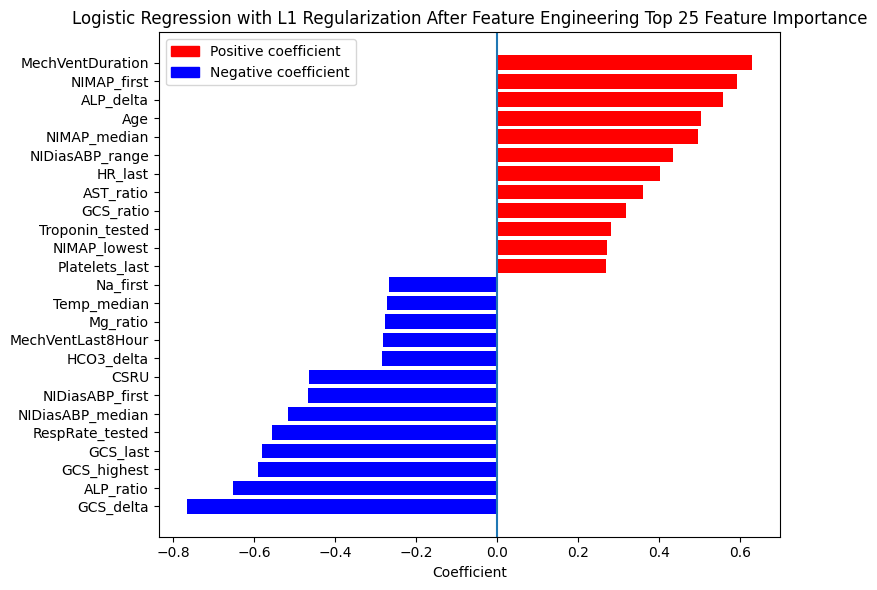

In [364]:
# Top 25 Features
util.plot_top25_feature_importance(coef_df_m2, model_name='Logistic Regression with L1 Regularization After Feature Engineering')

In [366]:
# Compare top 25 features before and after feature engineering

coef_df_before=coef_df.sort_values('abs_coef', ascending=False).head(25).rename(columns={'coef':'coef_before','abs_coef':'abs_coef_before'})
coef_df_after=coef_df_m2.sort_values('abs_coef', ascending=False).head(25).rename(columns={'coef':'coef_after','abs_coef':'abs_coef_after'})

top25_features_BeforeAfter=pd.merge(coef_df_before, coef_df_after, on='feature', how='outer')
top25_features_BeforeAfter.sort_values(by=['abs_coef_before','abs_coef_after'], ascending=False)

feature  coef_before  abs_coef_before  coef_after  \
12           GCS_last    -0.971454         0.971454   -0.582121   
15         HCO3_first     0.594474         0.594474         NaN   
18   MechVentDuration     0.575789         0.575789    0.629052   
31    RespRate_tested    -0.570162         0.570162   -0.556916   
24   NIDiasABP_median    -0.566966         0.566966   -0.516517   
28       NIMAP_median     0.563745         0.563745    0.495810   
26        NIMAP_first     0.555738         0.555738    0.592417   
11        GCS_highest    -0.508915         0.508915   -0.591789   
5                 Age     0.502285         0.502285    0.504467   
2            ALP_last     0.468166         0.468166         NaN   
8                CSRU    -0.466473         0.466473   -0.464978   
10          GCS_first     0.457654         0.457654         NaN   
22    NIDiasABP_first    -0.452144         0.452144   -0.466720   
6            BUN_last     0.398354         0.398354         NaN   
16          HCO3_last    -0.398070         0.398070         NaN   
17            HR_last     0.382940         0.382940    0.401739   
23  NIDiasABP_highest     0.362240         0.362240         NaN   
27       NIMAP_lowest     0.343114         0.343114    0.270170   
20    MechVent_tested    -0.333949         0.333949         NaN   
29           Na_first    -0.331035         0.331035   -0.266724   
1           ALP_first    -0.319501         0.319501         NaN   
34    Troponin_tested     0.277336         0.277336    0.280879   
33        Temp_median    -0.275478         0.275478   -0.271732   
32       SysABP_first    -0.271218         0.271218         NaN   
7      Bilirubin_last     0.267844         0.267844         NaN   
9           GCS_delta          NaN              NaN   -0.766116   
3           ALP_ratio          NaN              NaN   -0.652901   
0           ALP_delta          NaN              NaN    0.558848   
25    NIDiasABP_range          NaN              NaN    0.435599   
4           AST_ratio          NaN              NaN    0.359678   
13          GCS_ratio          NaN              NaN    0.318469   
14         HCO3_delta          NaN              NaN   -0.285442   
19  MechVentLast8Hour          NaN              NaN   -0.282414   
21           Mg_ratio          NaN              NaN   -0.278317   
30     Platelets_last          NaN              NaN    0.268092   

    abs_coef_after  
12        0.582121  
15             NaN  
18        0.629052  
31        0.556916  
24        0.516517  
28        0.495810  
26        0.592417  
11        0.591789  
5         0.504467  
2              NaN  
8         0.464978  
10             NaN  
22        0.466720  
6              NaN  
16             NaN  
17        0.401739  
23             NaN  
27        0.270170  
20             NaN  
29        0.266724  
1              NaN  
34        0.280879  
33        0.271732  
32             NaN  
7              NaN  
9         0.766116  
3         0.652901  
0         0.558848  
25        0.435599  
4         0.359678  
13        0.318469  
14        0.285442  
19        0.282414  
21        0.278317  
30        0.268092

In [367]:
coef_df_m2_zero_coef = coef_df_m2[coef_df_m2['coef'] == 0]
print('Number of features with zero coefficients after feature engineering:', coef_df_m2_zero_coef.shape[0])
coef_df_m2_zero_coef_list=coef_df_m2_zero_coef['feature'].sort_values().tolist()

Number of features with zero coefficients after feature engineering: 32


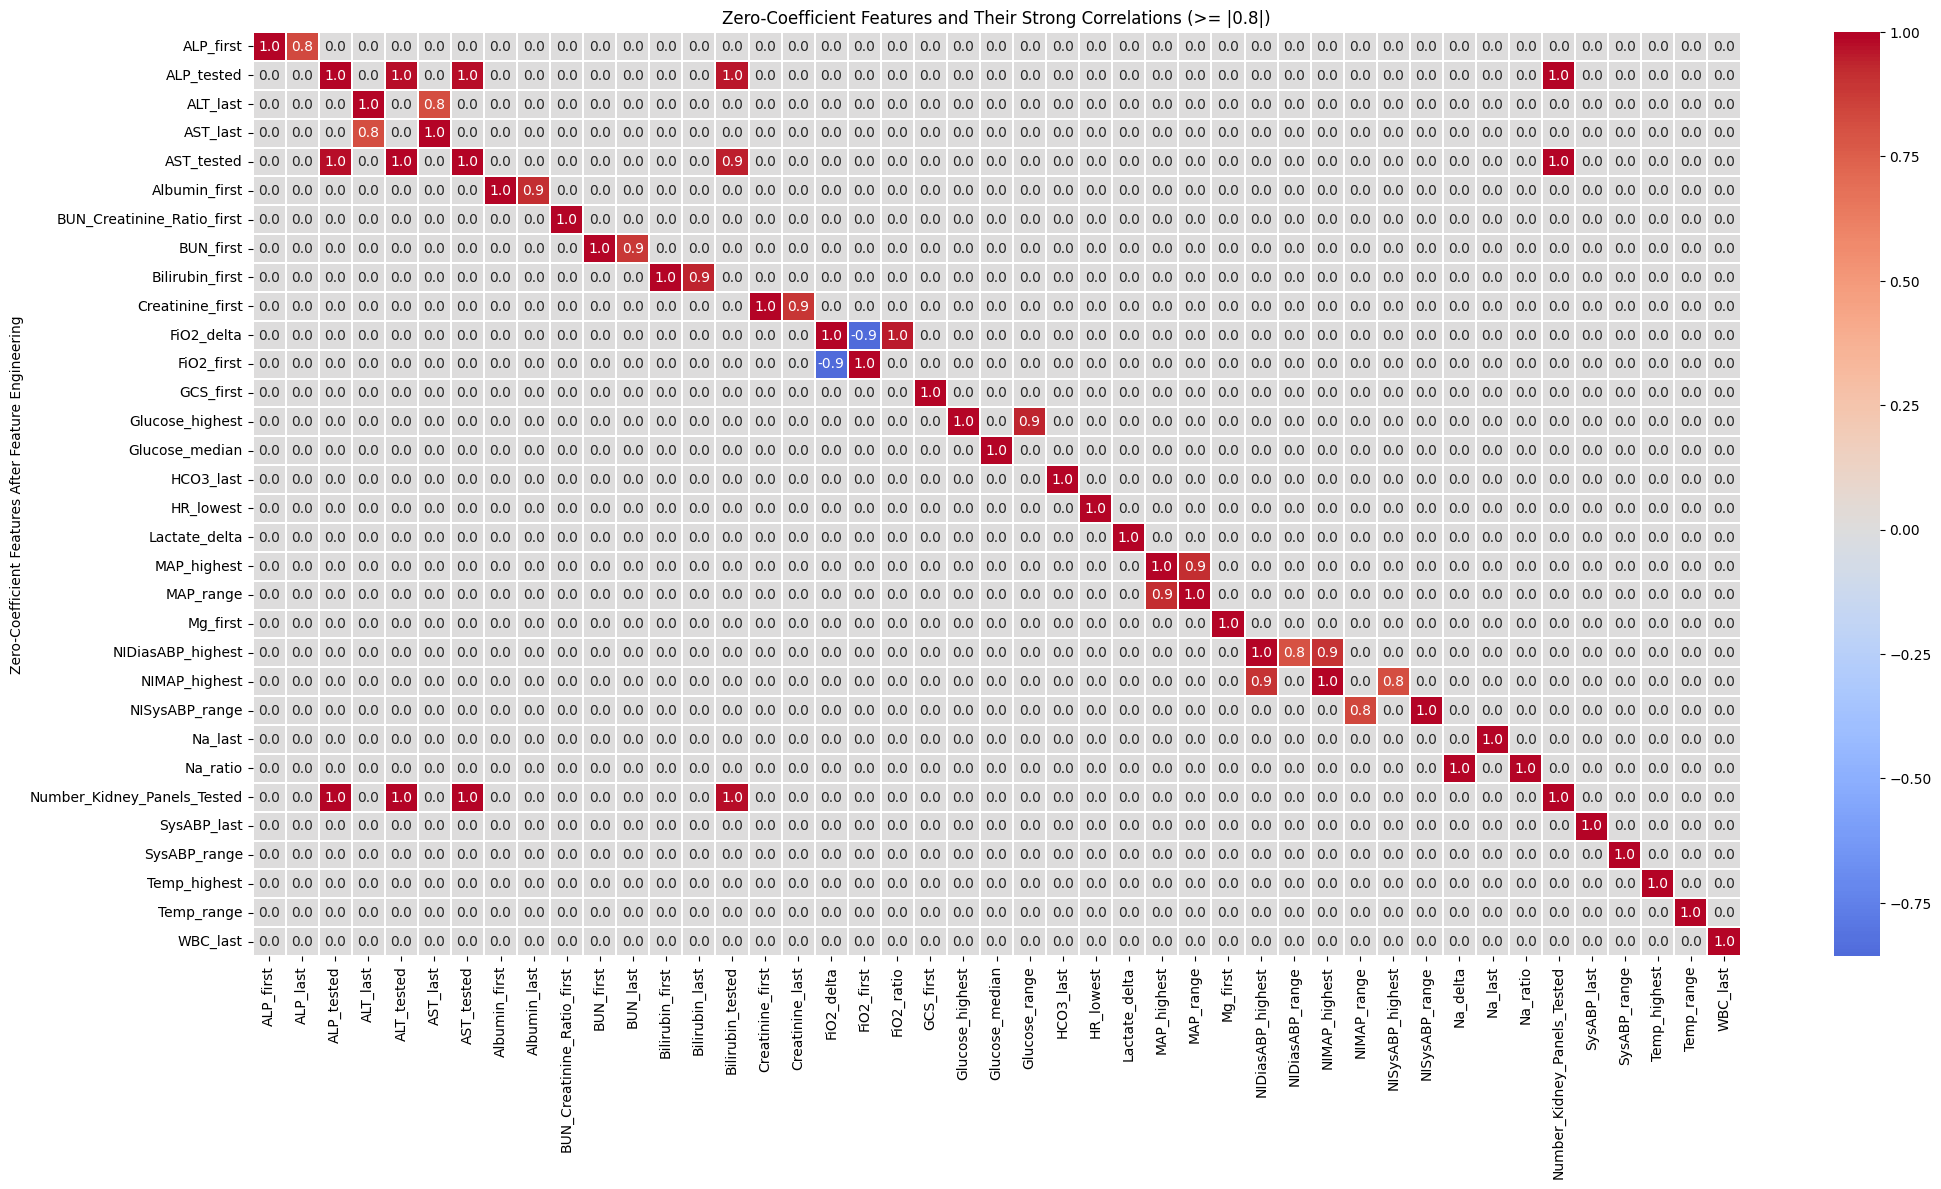

In [368]:
# Full correlation matrix
corr_matrix=X_train[sorted(X_train.columns)].corr()

# Columns where zero-coef features have |corr| >= 0.8
mask = (
    corr_matrix.loc[coef_df_m2_zero_coef_list, :].gt(0.8).any() |
    corr_matrix.loc[coef_df_m2_zero_coef_list, :].lt(-0.8).any()
)

correlated_features = corr_matrix.loc[coef_df_m2_zero_coef_list, mask]

# Mask weak correlations for cleaner visualization
corr_display = correlated_features.mask(
    (correlated_features < 0.8) & (correlated_features > -0.8)
)

# Heatmap
plt.figure(figsize=(24,12))
sns.heatmap(corr_display.fillna(0), annot=True, cmap='coolwarm', fmt=".1f", center=0, linewidths=0.2, annot_kws={"size":10})
plt.ylabel('Zero-Coefficient Features After Feature Engineering')
plt.title('Zero-Coefficient Features and Their Strong Correlations (>= |0.8|)')
plt.show()


In [369]:
# Find highly correlated pairs
threshold = 0.8
high_corr_pairs_idx = np.where(np.abs(corr_matrix) > threshold)

# Filter out duplicates and self-correlation
high_corr_pairs = [
    (corr_matrix.index[x], corr_matrix.columns[y], corr_matrix.iloc[x, y])
    for x, y in zip(*high_corr_pairs_idx) if x != y and x < y]

# Convert to DataFrame
high_corr_df = pd.DataFrame(high_corr_pairs, columns=["Feature_1", "Feature_2", "Correlation"])
high_corr_df = high_corr_df.sort_values(by="Correlation", ascending=False).reset_index(drop=True)

In [370]:
# Merge high correlation pairs with logistic regression coefficients
high_corr_df = high_corr_df.merge(coef_df_m2.rename(columns={'feature': 'Feature_1', 'coef': 'Coef_1', 'abs_coef': 'Abs_Coef_1 '}), on='Feature_1')
high_corr_df = high_corr_df.merge(coef_df_m2.rename(columns={'feature': 'Feature_2', 'coef': 'Coef_2', 'abs_coef': 'Abs_Coef_2 '}), on='Feature_2')
high_corr_df=high_corr_df.sort_values(by='Correlation', ascending=False)
high_corr_df=high_corr_df[['Feature_1','Feature_2','Correlation', 'Coef_1',   'Coef_2' ]].sort_values(['Feature_1','Feature_2'])

In [371]:
high_corr_df[(high_corr_df.Coef_1==0) | (high_corr_df.Coef_2==0)]

Feature_1                    Feature_2  Correlation    Coef_1  \
41          ALP_first                     ALP_last     0.829731  0.000000   
9          ALP_tested                   ALT_tested     0.974579  0.000000   
6          ALP_tested                   AST_tested     0.976259  0.000000   
12         ALP_tested             Bilirubin_tested     0.958874  0.000000   
3          ALP_tested  Number_Kidney_Panels_Tested     0.990422  0.000000   
47           ALT_last                     AST_last     0.812753  0.000000   
4          ALT_tested                   AST_tested     0.990136  0.113524   
5          ALT_tested  Number_Kidney_Panels_Tested     0.989995  0.113524   
14         AST_tested             Bilirubin_tested     0.948201  0.000000   
2          AST_tested  Number_Kidney_Panels_Tested     0.991675  0.000000   
19      Albumin_first                 Albumin_last     0.914515  0.000000   
31          BUN_first                     BUN_last     0.880752  0.000000   
16    Bilirubin_first               Bilirubin_last     0.941048  0.000000   
8    Bilirubin_tested  Number_Kidney_Panels_Tested     0.975387 -0.006127   
27   Creatinine_first              Creatinine_last     0.894041  0.000000   
56         FiO2_delta                   FiO2_first    -0.857031  0.000000   
13         FiO2_delta                   FiO2_ratio     0.951335  0.000000   
17    Glucose_highest                Glucose_range     0.939498  0.000000   
18        MAP_highest                    MAP_range     0.915368  0.000000   
49  NIDiasABP_highest              NIDiasABP_range     0.802326  0.000000   
25  NIDiasABP_highest                NIMAP_highest     0.905331  0.000000   
48      NIMAP_highest             NISysABP_highest     0.811430  0.000000   
40        NIMAP_range               NISysABP_range     0.836672 -0.212934   
1            Na_delta                     Na_ratio     0.995077  0.054768   

      Coef_2  
41  0.187469  
9   0.113524  
6   0.000000  
12 -0.006127  
3   0.000000  
47  0.000000  
4   0.000000  
5   0.000000  
14 -0.006127  
2   0.000000  
19 -0.031882  
31  0.155849  
16  0.175996  
8   0.000000  
27 -0.020182  
56  0.000000  
13  0.085017  
17 -0.009453  
18  0.000000  
49  0.435599  
25  0.000000  
48 -0.180008  
40  0.000000  
1   0.000000

## Model Summary – Logistic Regression (L1) with Temporal Features

After incorporating temporal features into the L1-regularized logistic regression model, the model shows an improvement in recall for the non-survived class, with:

- **Recall:** 0.77 (117/151)  
- **Precision:** 0.37 (113/316)  
- **Overall accuracy:** 78%  

This is based on the default threshold of 0.5 and represents an improvement over the baseline model with the same architecture.

After tuning the threshold to 0.44, the model achieves:

- **Recall:** 0.79 (120/151)  
- **Precision:** 0.35 (120/347) 
- **Overall accuracy:** 76%  

However, this performance does not exceed the threshold-tuned baseline model, which maintained a slightly higher recall and lower false positive rate.  

### Feature Importance Insights

Reviewing the top 25 features reveals that several temporal features contribute meaningfully to prediction, including:

- `BUN_delta`  
- `BUN_ratio`  
- `GCS_delta`  
- `HCO3_delta`  
- `Mg_ratio`  

Interestingly, `GCS_first`, which was among the top 25 baseline features, is assigned a zero coefficient in the new model. Correlation analysis shows no other features with |r| ≥ 0.8 relative to `GCS_first`, suggesting that the temporal features now provide more predictive signal. This shift likely reflects the imbalanced dataset, where the minority class (non-survived) is small, and temporal features better capture patient deterioration over time.

### Summary

Overall, model performance remains relatively stable compared to the baseline L1 logistic regression. Temporal features add interpretive value and highlight potential multivariate relationships in ICU outcomes. The presence of these temporal dynamics suggests that the underlying relationships may not be fully linear, motivating exploration of decision tree model (Random Forest).



# XGBoost

In [372]:
pos = np.sum(y_train)
neg = len(y_train) - pos
scale_pos_weight = neg / pos

scale_pos_weight

np.float64(6.045584045584046)

In [397]:

xgb_model = xgb.XGBClassifier(
    objective='binary:logistic',
    eval_metric='aucpr',          # better for imbalance
    n_estimators=100,
    learning_rate=0.1,
    max_depth=2,                  # shallow trees
    min_child_weight=10,          # VERY important for small positives
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=1,                # L1 regularization
    reg_lambda=1.5,               # L2 regularization
    scale_pos_weight=scale_pos_weight,
    random_state=42,
    n_jobs=-1,
    verbose=1
)

xgb_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='aucpr', feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=2,
              max_leaves=None, min_child_weight=10, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=100,
              n_jobs=-1, num_parallel_tree=None, ...)

In [398]:
y_prob_test = xgb_model.predict_proba(X_test)[:, 1]
y_prob_train = xgb_model.predict_proba(X_train)[:, 1]

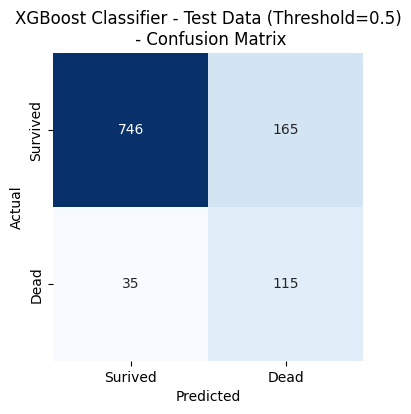

              precision    recall  f1-score   support

           0       0.96      0.82      0.88       911
           1       0.41      0.77      0.53       150

    accuracy                           0.81      1061
   macro avg       0.68      0.79      0.71      1061
weighted avg       0.88      0.81      0.83      1061



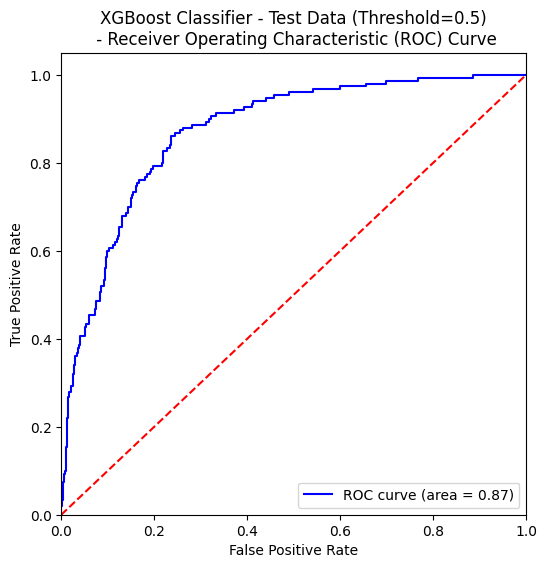

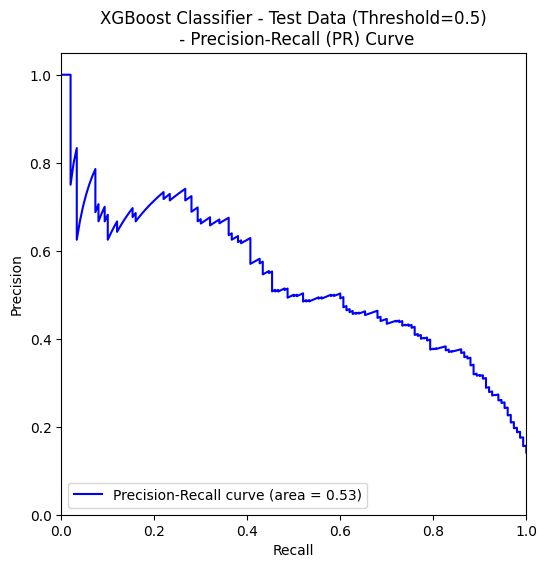

In [399]:
util.evaluate_classification_model(y_prob_test, 0.5, y_test, model_name='XGBoost Classifier - Test Data')

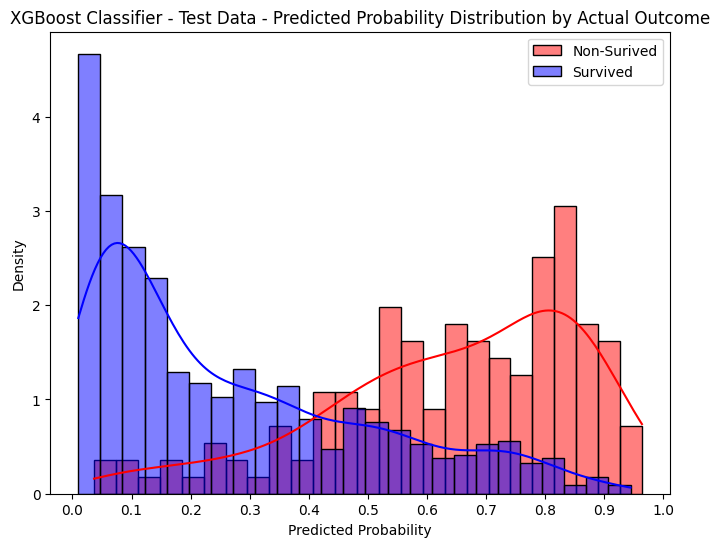

In [400]:
util.plot_threshold_distribution(y_prob_test, y_test, model_name='XGBoost Classifier - Test Data')

In [401]:
util.threshold_analysis(y_prob_test, y_test, threshold_range=np.arange(0.3, 0.725, 0.01))

Threshold 0.300 -> Recall: 0.913, FPR: 0.355, Precisinon: 0.298
Threshold 0.310 -> Recall: 0.913, FPR: 0.342, Precisinon: 0.305
Threshold 0.320 -> Recall: 0.907, FPR: 0.333, Precisinon: 0.310
Threshold 0.330 -> Recall: 0.907, FPR: 0.324, Precisinon: 0.316
Threshold 0.340 -> Recall: 0.893, FPR: 0.317, Precisinon: 0.317
Threshold 0.350 -> Recall: 0.887, FPR: 0.300, Precisinon: 0.328
Threshold 0.360 -> Recall: 0.887, FPR: 0.285, Precisinon: 0.338
Threshold 0.370 -> Recall: 0.880, FPR: 0.280, Precisinon: 0.341
Threshold 0.380 -> Recall: 0.880, FPR: 0.268, Precisinon: 0.351
Threshold 0.390 -> Recall: 0.873, FPR: 0.258, Precisinon: 0.358
Threshold 0.400 -> Recall: 0.867, FPR: 0.250, Precisinon: 0.363
Threshold 0.410 -> Recall: 0.867, FPR: 0.246, Precisinon: 0.367
Threshold 0.420 -> Recall: 0.860, FPR: 0.237, Precisinon: 0.374
Threshold 0.430 -> Recall: 0.840, FPR: 0.235, Precisinon: 0.371
Threshold 0.440 -> Recall: 0.827, FPR: 0.228, Precisinon: 0.373
Threshold 0.450 -> Recall: 0.827, FPR: 0

In [402]:
XGBoost_Selected_Threshold=0.41

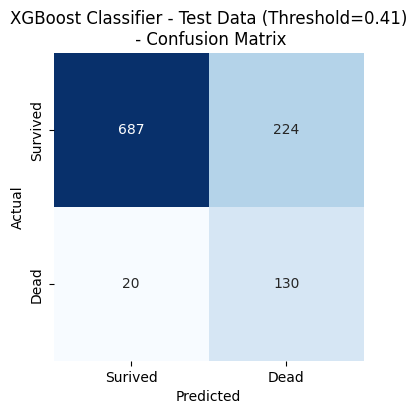

              precision    recall  f1-score   support

           0       0.97      0.75      0.85       911
           1       0.37      0.87      0.52       150

    accuracy                           0.77      1061
   macro avg       0.67      0.81      0.68      1061
weighted avg       0.89      0.77      0.80      1061



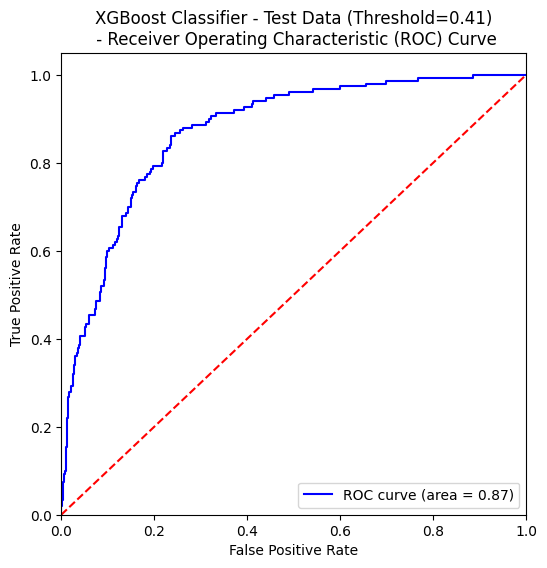

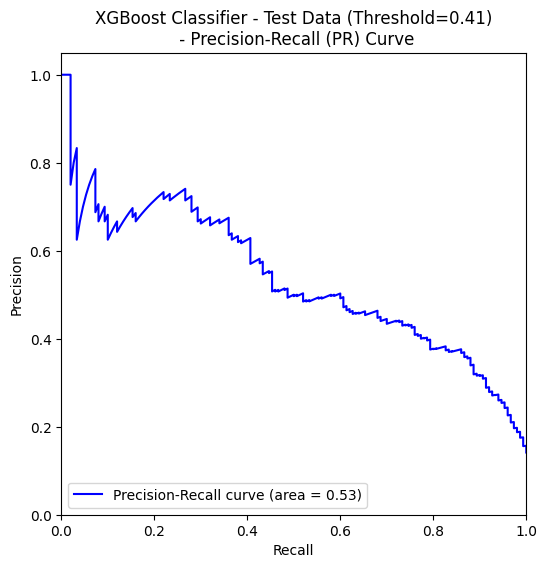

In [403]:
util.evaluate_classification_model(y_prob_test,XGBoost_Selected_Threshold, y_test, model_name='XGBoost Classifier - Test Data') 

## Feature Importances

In [388]:
xgb_importance_dict = xgb_model.get_booster().get_score(importance_type='gain') # Average gain of splits which use the feature
xgb_importance_df=pd.DataFrame(xgb_importance_dict.items(), columns=['feature', 'gain'])
xgb_importance_df=xgb_importance_df.sort_values(by='gain', ascending=False)

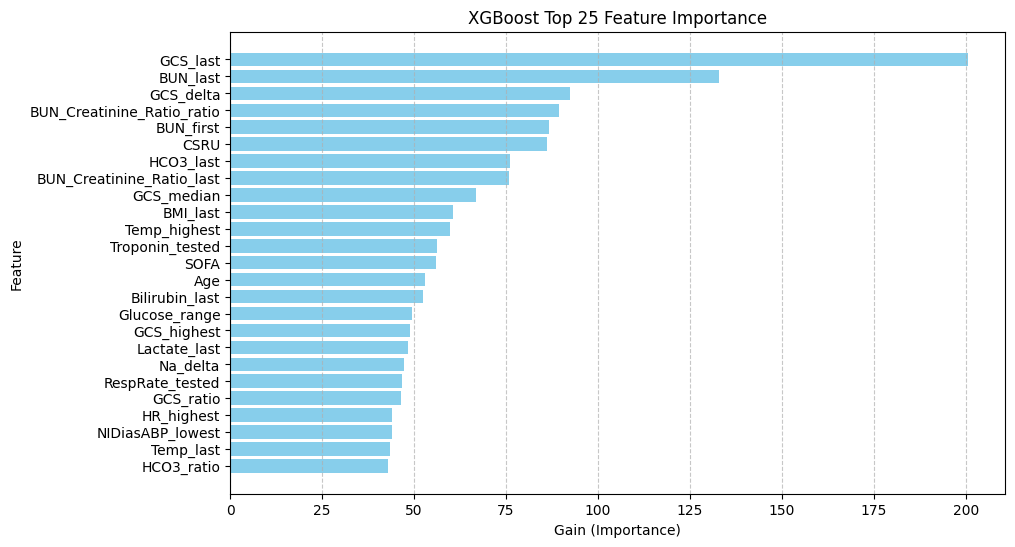

In [389]:
plt.figure(figsize=(10,6))
plt.barh(
    xgb_importance_df['feature'].head(25),
    xgb_importance_df['gain'].head(25),
    color='skyblue')
plt.title('XGBoost Top 25 Feature Importance')
plt.xlabel('Gain (Importance)')
plt.ylabel('Feature')
plt.gca().invert_yaxis()
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

## Shap Values

In [390]:
explainer=shap.TreeExplainer(xgb_model, X_train)
# Compute SHAP values for test set
shap_values_test = explainer(X_test)

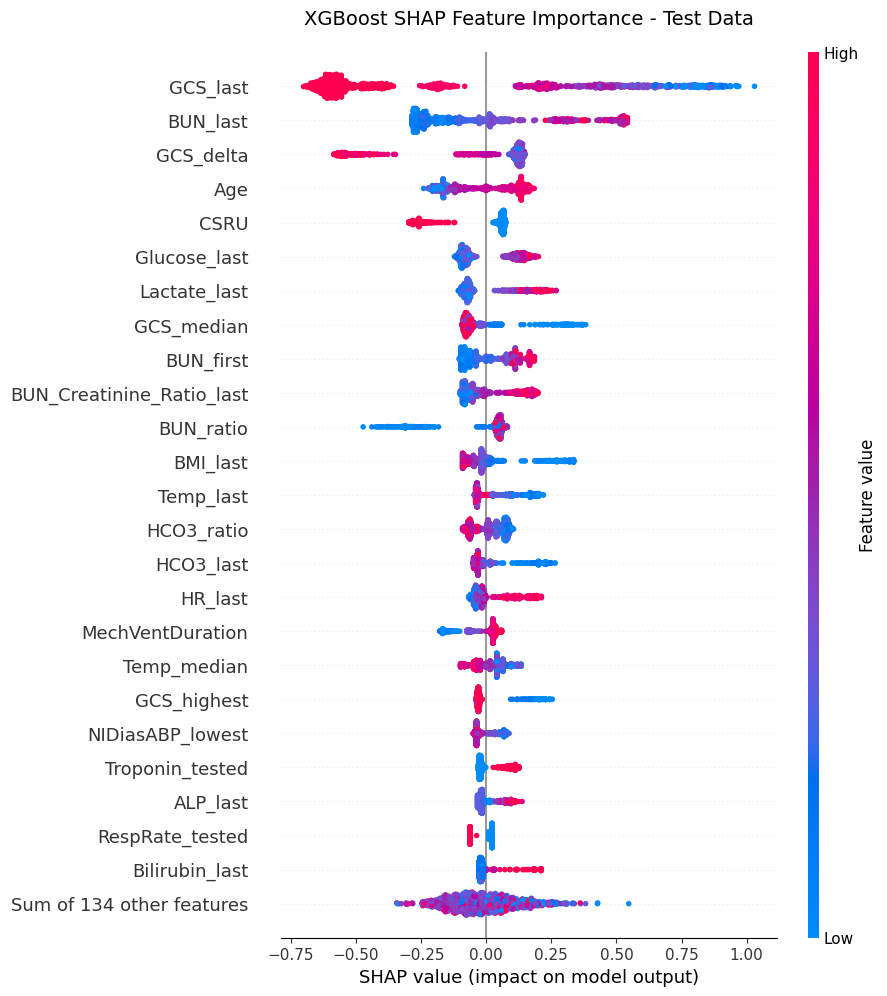

In [391]:
shap.plots.beeswarm(shap_values_test, max_display=25, show=False)
plt.title('XGBoost SHAP Feature Importance - Test Data', fontsize=14, pad=20)
plt.show()

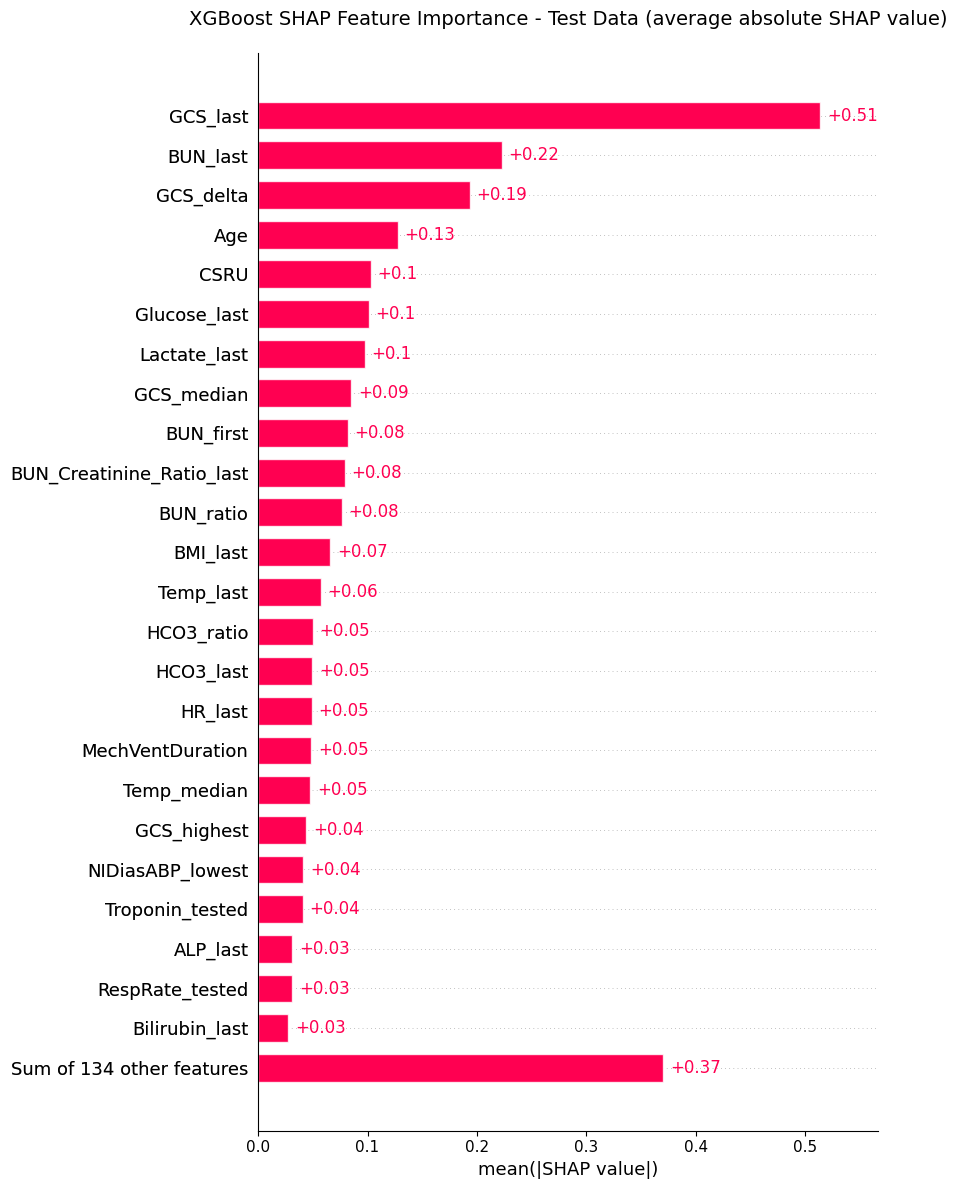

In [392]:
shap.plots.bar(shap_values_test, max_display=25, show=False)
plt.title('XGBoost SHAP Feature Importance - Test Data (average absolute SHAP value)', fontsize=14, pad=20)
plt.show()

## Decision Trees

<Figure size 2400x1800 with 0 Axes>

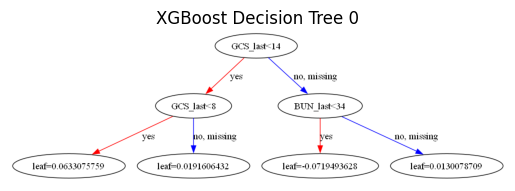

<Figure size 2400x1800 with 0 Axes>

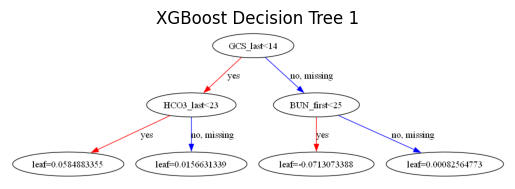

<Figure size 2400x1800 with 0 Axes>

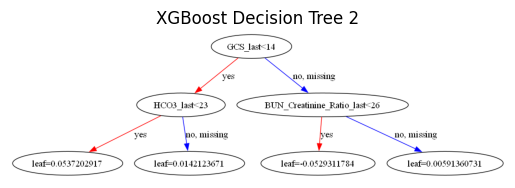

<Figure size 2400x1800 with 0 Axes>

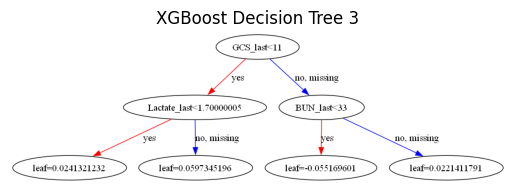

<Figure size 2400x1800 with 0 Axes>

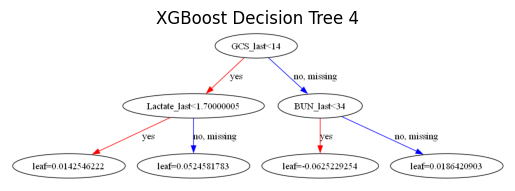

In [393]:
for i in range(5):
    plt.figure(figsize=(24, 18))
    xgb.plot_tree(xgb_model, num_trees=i, max_depth=2)
    plt.title(f"XGBoost Decision Tree {i}")
    plt.savefig(r'./figures/xgb_tree_'+str(i)+'.png', dpi=800, bbox_inches='tight')   # high-res raster
    plt.show()

## Error Analysis

In [394]:
y_pred_xgb=(y_prob_test >=0.46).astype(int)
y_pred_xgb
y_pred_xgb=(y_prob_test >=XGBoost_Selected_Threshold).astype(int)

In [395]:
# Test results dataframe
test_results=pd.DataFrame({'y_true': y_test,'y_pred': y_pred_xgb, 'y_prob': y_prob_test}).reset_index(drop=True)

misclassified_dead=test_results[(test_results['y_true'] ==1) & (test_results['y_pred'] == 0)].index.tolist()
misclassified_surived=test_results[(test_results['y_true'] ==0) & (test_results['y_pred'] == 1)].index.tolist()

896


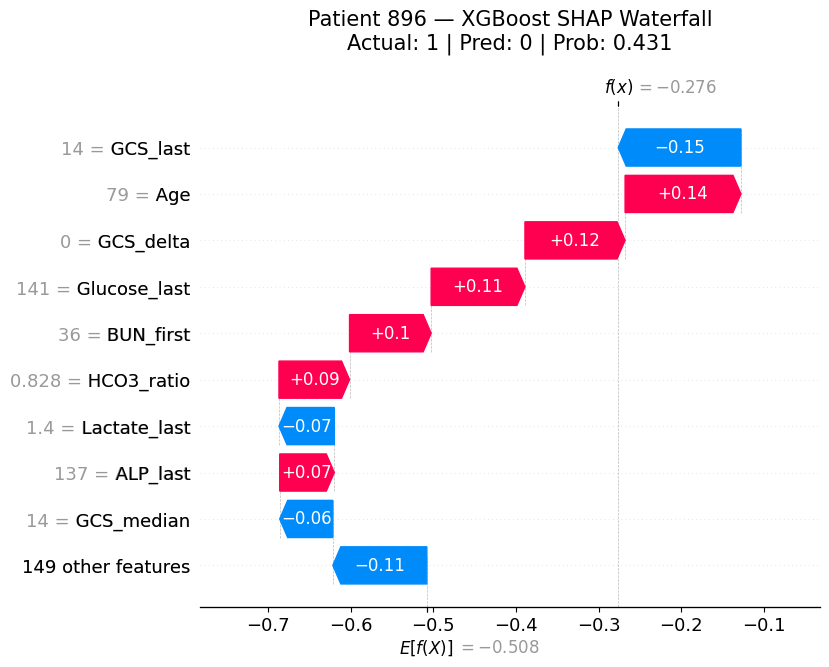

918


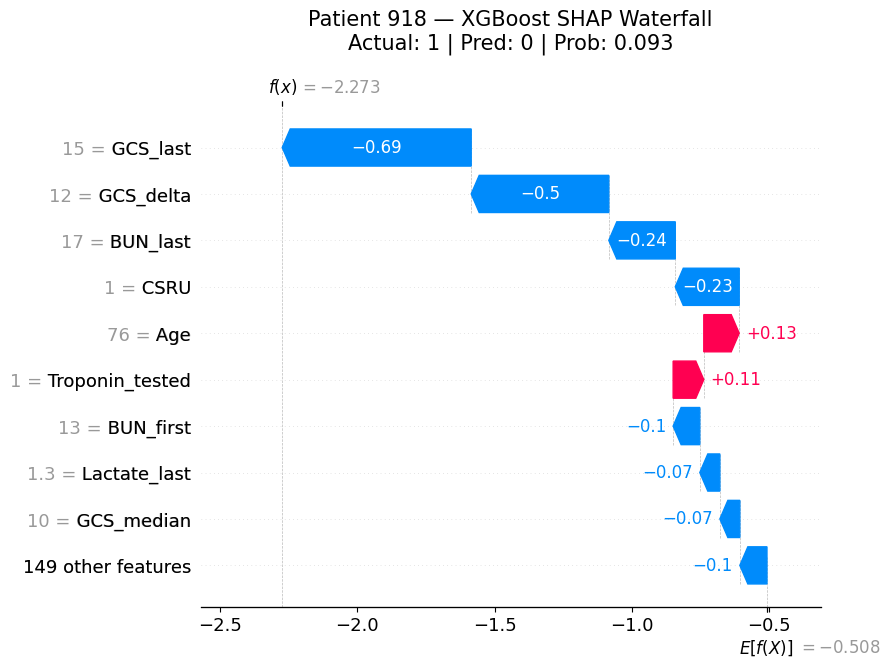

973


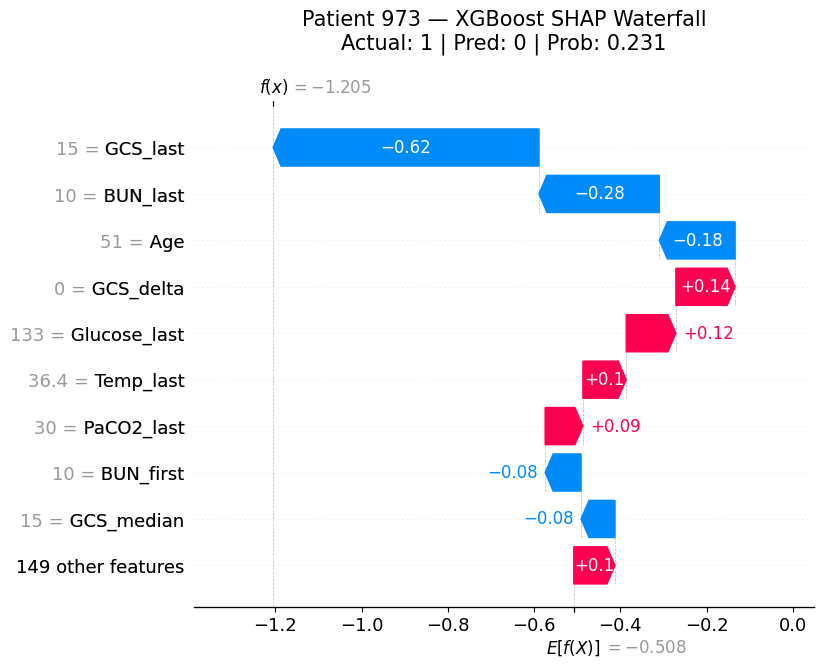

1034


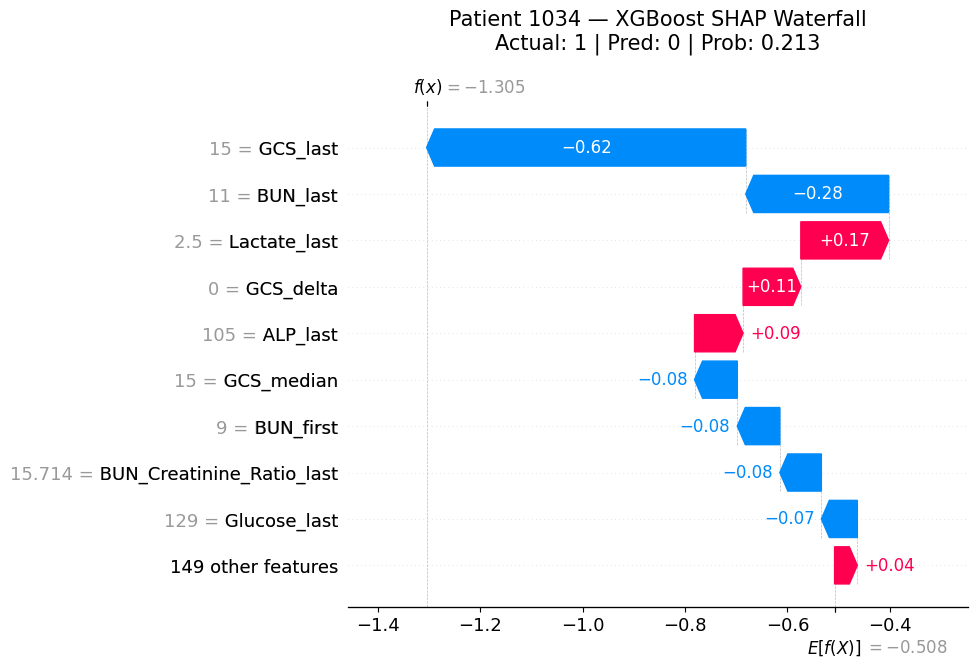

1043


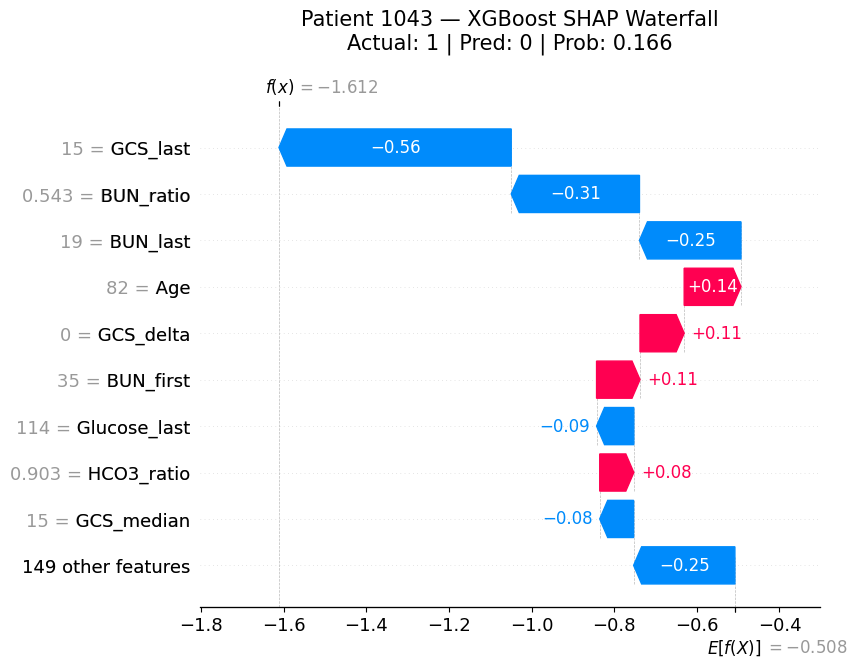

1046


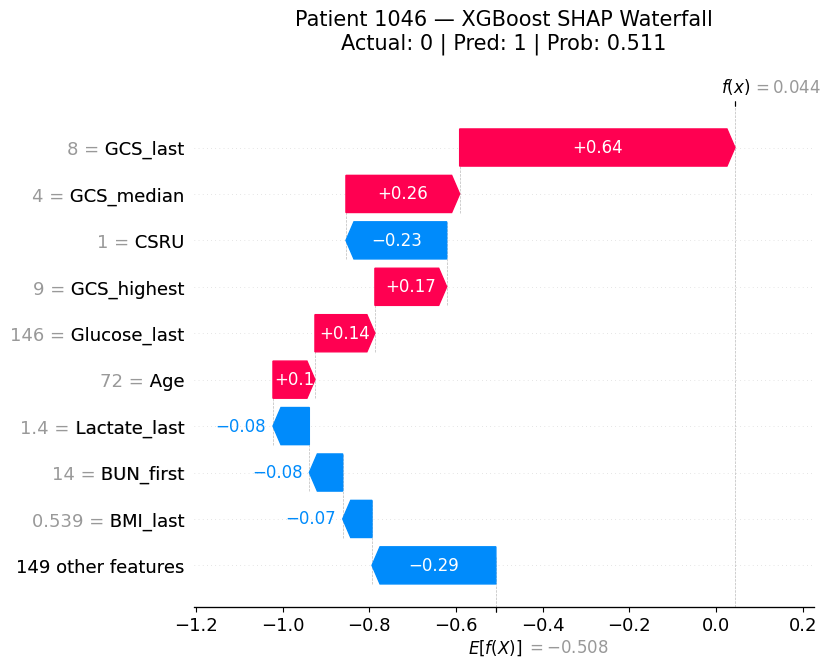

1047


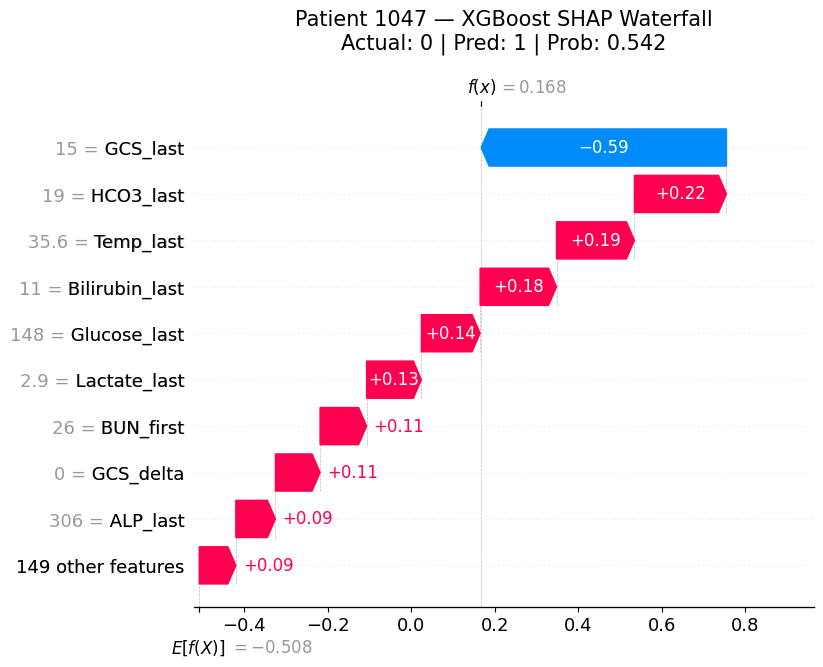

1052


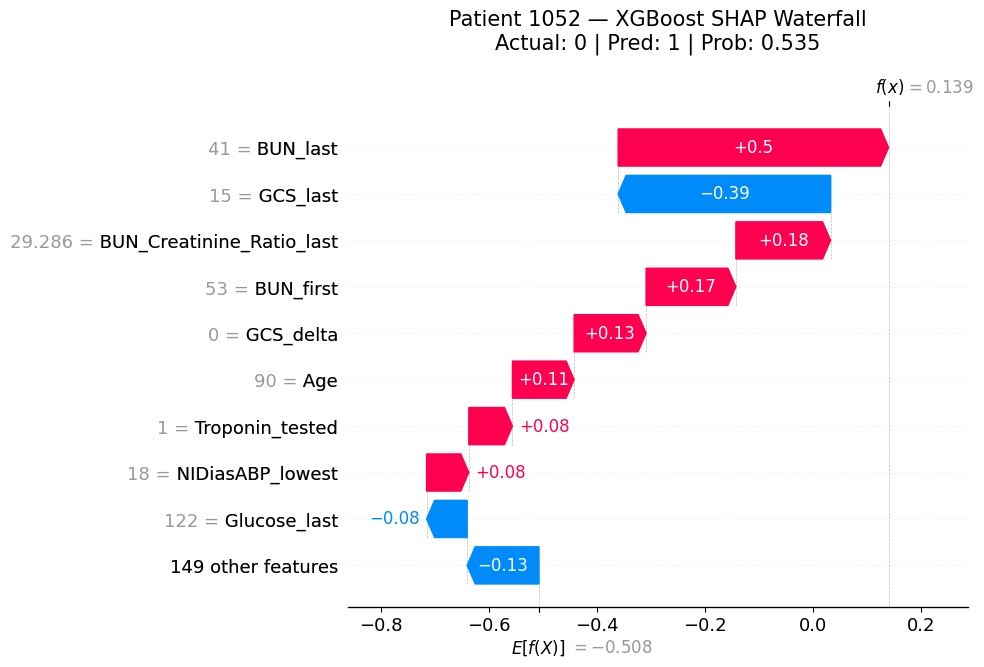

1053


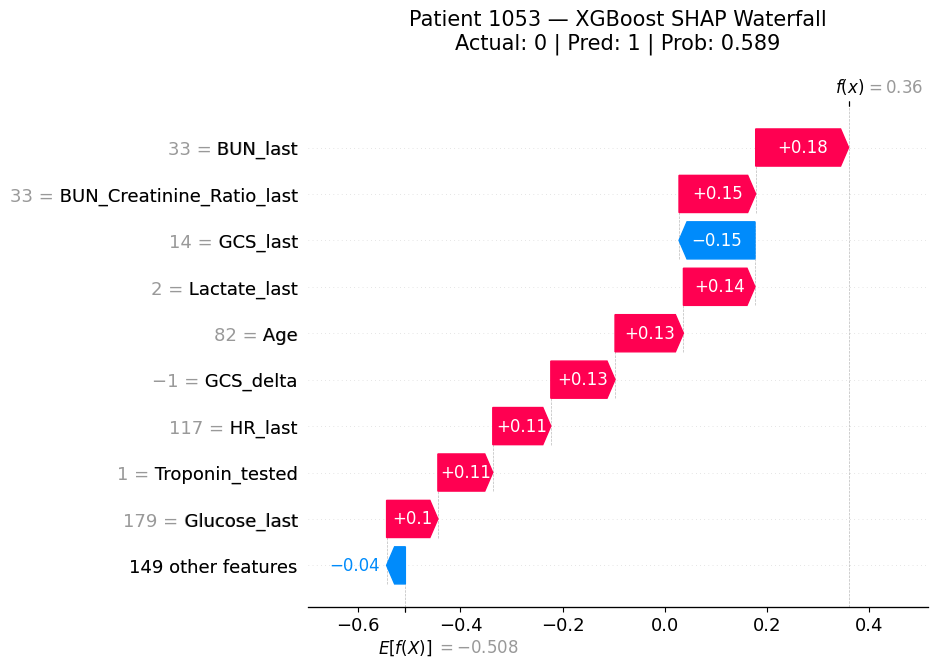

1057


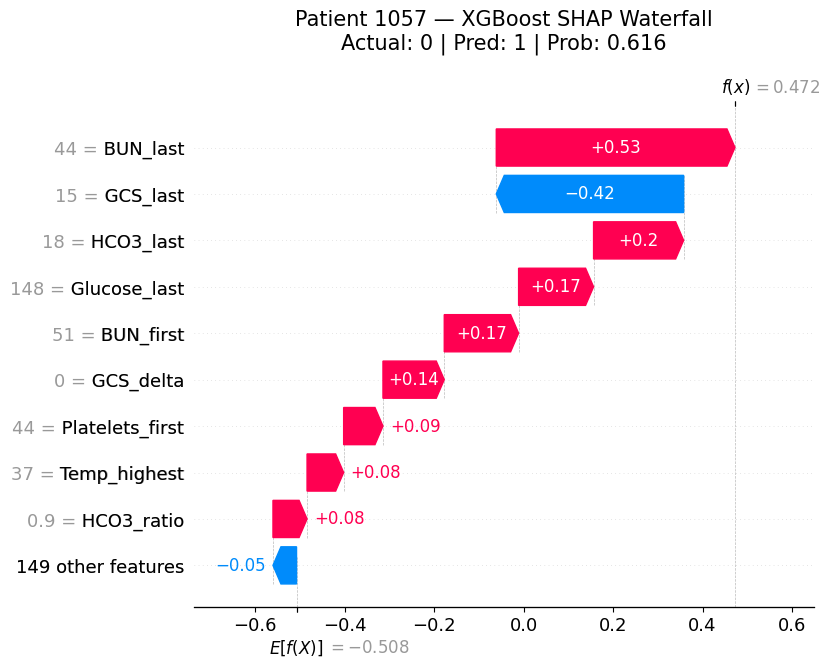

In [396]:
# Last 5 misclassified dead patients and Last 5 misclassified survived patients
missclassified_list=misclassified_dead[-5:]+misclassified_surived[-5:]

for index_id in missclassified_list:
    print(index_id)
    shap.plots.waterfall(shap_values_test[index_id],show=False)
    plt.title(
        f"Patient {index_id} — XGBoost SHAP Waterfall\n"
        f"Actual: {int(test_results.iloc[index_id]['y_true'])} | "
        f"Pred: {int(test_results.iloc[index_id]['y_pred'])} | "
        f"Prob: {test_results.iloc[index_id]['y_prob']:.3f}",
        fontsize=15,
        pad=20
    )
    plt.show()


## XGBoost Summary

XGboost shows an overall accuracy of 79%, recall at 0.77 (117/151) and a precision of 0.58 (177/305) with the default threshold at 0.5. The results appear to be aligned with the logistic regression L1 regularization models with a decreased of 0.1 in recall from 0.78 (118/151), but a 0.13 increase in precision from 0.37 (118/321). 

By tuning threshold of the XGboost model to 0.45, the overall accuracy has reduced to 77%, but an increased in recall for the mortility patients to 0.83 (126/151), and a decreased in precision to 0.36 (126/353).
